In [1]:
import logging
# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
import time
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
# plotting
%matplotlib notebook
%matplotlib inline

/home/andy/miniconda3/envs/sblines3/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start = time.time()

In [4]:
# 随机种子(random seeds) : 14,15,16,2025,3407,3408
seed2 = 15

# 设置随机种子
np.random.seed(seed2)
random.seed(seed2)
torch.manual_seed(seed2)
torch.cuda.manual_seed(seed2)
torch.cuda.manual_seed_all(seed2)

# # 保存这些种子值以便之后打印
# seeds_dict = {
#     'numpy_seed': seed2,
#     'random_seed': seed2,
#     'torch_seed': seed2,
#     'cuda_seed': seed2,
#     'cuda_all_seed': seed2
# }

In [5]:
# params
window_length = 50
steps = 128
test_steps = 252  # 回测步数（一年）

In [6]:
# save dir
# save_dir = "./outputs/pytorch-DDPG/"
# os.makedirs(save_dir, exist_ok=True)

# Environment Definition

In [7]:
# from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.callbacks.notebook_plot import LivePlotNotebook
from rl_portfolio_management.config import eps

In [8]:
from rl_portfolio_management.util import sharpe

class DataSrc(object):
    """Acts as data provider for each new episode."""

    def __init__(self, 
                 df,
                 steps=252, 
                 scale=True, scale_extra_cols=True, augment=0.00, window_length=50, random_reset=True):
        """
        DataSrc.

        df - csv for data frame index of timestamps
             and multi-index columns levels=[['LTCBTC'],...],['open','low','high','close',...]]
             an example is included as an hdf file in this repository
        steps - total steps in episode
        scale - scale the data for each episode
        scale_extra_cols - scale extra columns by global mean and std
        augment - fraction to augment the data by
        random_reset - reset to a random time (otherwise continue through time)
        """
        self.steps = steps + 1
        self.augment = augment
        self.random_reset = random_reset
        self.scale = scale
        self.scale_extra_cols = scale_extra_cols
        self.window_length = window_length
        self.idx = self.window_length
        


        # get rid of NaN's
        df = df.copy()
        df.replace(np.nan, 0, inplace=True)
        df = df.fillna(method="pad")

        # dataframe to matrix
        self.asset_names = df.columns.levels[0].tolist()
        self.features = df.columns.levels[1].tolist()
        data = df.values.reshape(
            (len(df), len(self.asset_names), len(self.features)))
        self._data = np.transpose(data, (1, 0, 2))
        self._times = df.index

        self.price_columns = ['close', 'high', 'low', 'open']
        self.non_price_columns = set(
            df.columns.levels[1]) - set(self.price_columns)

        # Stats to let us normalize non price columns
        if scale_extra_cols:
            x = self._data.reshape((-1, len(self.features)))
            self.stats = dict(mean=x.mean(0), std=x.std(0))
            # for column in self._data.columns.levels[1].tolist():
            #     x = df.xs(key=column, axis=1, level='Price').as_matrix()[:, :]
            #     self.stats["mean"].append(x.mean())
            #      = dict(mean=x.mean(), std=x.std())

        self.reset()

    def _step(self):
        # get history matrix from dataframe
        data_window = self.data[:, self.step:self.step +
                                self.window_length].copy()

        # (eq.1) prices
        y1 = data_window[:, -1, 0] / data_window[:, -2, 0]
        y1 = np.concatenate([[1.0], y1])  # add cash price

        # (eq 18) X: prices are divided by close price
        nb_pc = len(self.price_columns)
        if self.scale:
            last_close_price = data_window[:, -1, 0]
            data_window[:, :, :nb_pc] /= last_close_price[:,
                                                          np.newaxis, np.newaxis]

        if self.scale_extra_cols:
            # normalize non price columns
            data_window[:, :, nb_pc:] -= self.stats["mean"][None, None, nb_pc:]
            data_window[:, :, nb_pc:] /= self.stats["std"][None, None, nb_pc:]
            data_window[:, :, nb_pc:] = np.clip(
                data_window[:, :, nb_pc:],
                self.stats["mean"][nb_pc:] - self.stats["std"][nb_pc:] * 10,
                self.stats["mean"][nb_pc:] + self.stats["std"][nb_pc:] * 10
            )
            data_window[np.isinf(data_window)] = 0
            data_window[np.isnan(data_window)] = 0

        self.step += 1
        history = data_window
        done = bool(self.step >= self.steps)

        return history, y1, done

    def reset(self):
        self.step = 0

        # get data for this episode
        if self.random_reset:
            self.idx = np.random.randint(
                low=self.window_length + 1, high=self._data.shape[1] - self.steps - 2)
        else:
            # 总是从数据集的起始位置开始（该功能主要用在测试集中）
            self.idx = self.window_length + 1
            
#             # continue sequentially, before reseting to start
#             if self.idx>(self._data.shape[1] - self.steps - self.window_length - 1):
#                 self.idx=self.window_length + 1
#             else:
#                 self.idx += self.steps

        data = self._data[:, self.idx -
                          self.window_length:self.idx + self.steps + 1].copy()
        self.times = self._times[self.idx -
                                 self.window_length:self.idx + self.steps + 1]

        # augment data to prevent overfitting
        data += np.random.normal(loc=0, scale=self.augment, size=data.shape)

        self.data = data


class PortfolioSim(object):
    """
    Portfolio management sim.

    Params:
    - cost e.g. 0.0015 

    Based of [Jiang 2017](https://arxiv.org/abs/1706.10059)
    """

    def __init__(self, asset_names=[], steps=128, trading_cost=0.0015, time_cost=0.0):
        self.cost = trading_cost
        self.time_cost = time_cost
        self.steps = steps
        self.asset_names = asset_names
        self.reset()

    def _step(self, w1, y1):
        """
        Step.

        w1 - new action of portfolio weights - e.g. [0.1,0.9, 0.0]
        y1 - price relative vector also called return
            e.g. [1.0, 0.9, 1.1]
        Numbered equations are from https://arxiv.org/abs/1706.10059
        """
        w0 = self.w0
        p0 = self.p0
        #
        # print("y1:",y1)
        # print("w1",w1)
        dw1 = (y1 * w0) / (np.dot(y1, np.abs(w0)) + eps)  # (eq7) weights evolve into
        # print("w0:",w0)
        # (eq16) cost to change portfolio
        # (excluding change in cash to avoid double counting for transaction cost)
        c1 = self.cost * (
            np.abs(dw1[1:] - w1[1:])).sum()

        p1 = p0 * (1 - c1) * np.exp(np.dot(np.log(y1), w0))  # (eq11) final portfolio value

        p1 = p1 * (1 - self.time_cost)  # we can add a cost to holding

        # can't have negative holdings in this model (no shorts)
        # p1 = np.clip(p1, 0, np.inf)

        rho1 = p1 / p0 - 1  # rate of returns
        r1 = np.log((p1 + eps) / (p0 + eps))  # (eq10) log rate of return
        # r1 = np.log(1 - c1) + np.dot(np.log(y1), w0)  # (eq10) log rate of return
        # (eq22) immediate reward is log rate of return scaled by episode length
        
        self.ret.append(r1) # 把收益率保存在容器中
        reward = sharpe(np.array(self.ret)) / self.steps
              

        # remember for next step
        self.w0 = w1
        self.p0 = p1


        # if we run out of money, we're done
        done = bool(p1 == 0)

        # should only return single values, not list
        info = {
            "reward": reward,
            "log_return": r1,
            "portfolio_value": p1,
            "market_return": y1.mean(),
            "rate_of_return": rho1,
            "weights_mean": w1.mean(),
            "weights_std": w1.std(),
            "cost": c1,
        }
        # record weights and prices
        for i, name in enumerate(['CASH'] + self.asset_names):
            info['weight_' + name] = w1[i]
            info['price_' + name] = y1[i]

        self.infos.append(info)
        return reward, info, done

    def reset(self):
        self.infos = []
        self.w0 = np.array([1.0] + [0.0] * len(self.asset_names))
        self.p0 = 1.0
        self.ret = [] # 定义一个容器，保存收益率，用作sharpe比率计算


class PortfolioEnv(gym.Env):
    """
    An environment for financial portfolio management.

    Financial portfolio management is the process of constant redistribution of a fund into different
    financial products.

    Based on [Huang 2020](https://arxiv.org/abs/2012.13773)
    """
    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['notebook', 'ansi']}

    
    def __init__(self,
                 df,
                 steps=256,
                 trading_cost=0.0015,
                 time_cost=0.00,
                 window_length=50,
                 augment=0.00,
                 output_mode='DRLshort',
                 log_dir=None,
                 scale=True,
                 scale_extra_cols=True,
                 random_reset=True
                 ):
        """
        An environment for financial portfolio management.

        Params:
            df - csv for data frame index of timestamps
                 and multi-index columns levels=[['LTCBTC'],...],['open','low','high','close']]
            steps - steps in episode
            window_length - how many past observations["history"] to return
            trading_cost - cost of trade as a fraction,  e.g. 0.0025 corresponding to max rate of 0.25% at Poloniex (2017)
            time_cost - cost of holding as a fraction
            augment - fraction to randomly shift data by
            output_mode: decides observation["history"] shape
            - 'EIIE' for (assets, window, 3)
            - 'atari' for (window, window, 3) (assets is padded)
            - 'mlp' for (assets*window*3)
            log_dir: directory to save plots to
            scale - scales price data by last opening price on each episode (except return)
            scale_extra_cols - scales non price data using mean and std for whole dataset
        """
        super(PortfolioEnv, self).__init__()
        self.src = DataSrc(df=df, steps=steps, scale=scale, scale_extra_cols=scale_extra_cols,
                           augment=augment, window_length=window_length,
                           random_reset=random_reset)
        self._plot = self._plot2 = self._plot3 = None
        self.output_mode = output_mode
        self.sim = PortfolioSim(
            asset_names=self.src.asset_names,
            trading_cost=trading_cost,
            time_cost=time_cost,
            steps=steps)
        self.log_dir = log_dir

        # openai gym attributes
        # action will be the portfolio weights [cash_bias,w1,w2...] where wn are [-1, 1] for each asset
        nb_assets = len(self.src.asset_names)
        self.action_space = gym.spaces.Box(-1.0, 1.0, shape=(nb_assets + 1,), dtype=np.float32)
        
        # get the history space from the data min and max
        if output_mode == 'DRLshort':
            obs_shape = (
                nb_assets,
                window_length,
                len(self.src.features)
            )
            
        self.observation_space = gym.spaces.Dict({
            'history': gym.spaces.Box(
                -10,
                20 if scale else 1,  # if scale=True observed price changes return could be large fractions
                obs_shape
            ),
            'weights': self.action_space    
        })
        
    def reset(self):
        self.sim.reset()
        self.src.reset()
        self.infos = []
        action = self.sim.w0
        observation, reward, done, info = self.step(action)
        return observation
    
    def step(self, action):
        """
        Step the env.

        Actions should be portfolio [w0...]
        - Where wn is a portfolio weight between 0 and 1. The first (w0) is cash_bias
        - cn is the portfolio conversion weights see PortioSim._step for description
        """
        logger.debug('action: %s', action)
#         weights = np.clip(action, -1.0, 1.0)
#         weights[0] = np.clip(weights[0], 0, 1)
#         weights_abs = np.abs(weights)
#         weights /= weights_abs.sum() + eps
        # print('weights:',weights)
        weights = action
        if np.all(weights==0):
            weights[0] = 1        
        
        weights_abs = np.abs(weights)
        weights /= weights_abs.sum()

        # Sanity checks
        assert self.action_space.contains(
            action), 'action should be within %r but is %r' % (self.action_space, action)
        np.testing.assert_almost_equal(
            np.sum(np.abs(weights)), 1.0, 3, err_msg='weights should sum to 1. action="%s"' % weights)

        history, y1, done1 = self.src._step()

        reward, info, done2 = self.sim._step(weights, y1)

        # calculate return for buy and hold a bit of each asset
        info['market_value'] = np.cumprod(
            [inf["market_return"] for inf in self.infos + [info]])[-1]
        # add dates
        info['date'] = self.src.times[self.src.step].timestamp()
        info['steps'] = self.src.step

        self.infos.append(info)

        # reshape history according to output mode
        if self.output_mode == 'DRLshort':
            pass
        elif self.output_mode == 'atari':
            padding = history.shape[1] - history.shape[0]
            history = np.pad(history, [[0, padding], [
                0, 0], [0, 0]], mode='constant')
        elif self.output_mode == 'mlp':
            history = history.flatten()

        return {'history': history, 'weights': weights}, reward, done1 or done2, info
    
    def _seed(self, seed):
        np.random.seed(seed)
        return [seed]

    def render(self, mode='notebook', close=False):
        # if close:
            # return
        if mode == 'ansi':
            pprint(self.infos[-1])
        elif mode == 'notebook':
            self.plot_notebook(close)

    def plot_notebook(self, close=False):
        """Live plot using the jupyter notebook rendering of matplotlib."""

        if close:
            self._plot = self._plot2 = self._plot3 = None
            return

        df_info = pd.DataFrame(self.infos)
        df_info.index = pd.to_datetime(df_info["date"], unit='s')

        # plot prices and performance
        all_assets = ['CASH'] + self.sim.asset_names
        if not self._plot:
            colors = [None] * len(all_assets) + ['black']
            self._plot_dir = os.path.join(
                self.log_dir, 'notebook_plot_prices_' + str(time.time())) if self.log_dir else None
            self._plot = LivePlotNotebook(
                log_dir=self._plot_dir, title='prices & performance', labels=all_assets + ["Portfolio"], ylabel='value', colors=colors)
        x = df_info.index
        y_portfolio = df_info["portfolio_value"]
        y_assets = [df_info['price_' + name].cumprod()
                    for name in all_assets]
        self._plot.update(x, y_assets + [y_portfolio])


        # plot portfolio weights
        if not self._plot2:
            self._plot_dir2 = os.path.join(
                self.log_dir, 'notebook_plot_weights_' + str(time.time())) if self.log_dir else None
            self._plot2 = LivePlotNotebook(
                log_dir=self._plot_dir2, labels=all_assets, title='weights', ylabel='weight')
        ys = [df_info['weight_' + name] for name in all_assets]
        self._plot2.update(x, ys)

        # plot portfolio costs
        if not self._plot3:
            self._plot_dir3 = os.path.join(
                self.log_dir, 'notebook_plot_cost_' + str(time.time())) if self.log_dir else None
            self._plot3 = LivePlotNotebook(
                log_dir=self._plot_dir3, labels=['cost'], title='costs', ylabel='cost')
        ys = [df_info['cost']]
        self._plot3.update(x, ys)

        if close:
            self._plot = self._plot2 = self._plot3 = None



# APPLY ENV

In [9]:
from rl_portfolio_management.util import MDD, sharpe, softmax, MDD1, sortino, calmar, other_metrics
from rl_portfolio_management.wrappers import TanhActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/chinaStock_1d_vol.hf',key='train')
df_test = pd.read_hdf('./data/chinaStock_1d_vol.hf',key='test')

In [10]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
#         reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [11]:
env = PortfolioEnv(df=df_train, steps=steps, output_mode='DRLshort')

In [12]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='DRLshort', random_reset=True)
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = TanhActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test(df=df_test, steps=test_steps):
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='DRLshort', random_reset=False)
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = TanhActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 10), (4, 51, 10))

In [13]:
# task.observation_space

In [14]:
# Instantiate the env
env = task_fn()

In [15]:
# env_test = task_fn_test()

try:
    env_test = task_fn_test(df=df_test, steps=test_steps)
except  ValueError:
    print("回测区间数据量不够，请增加回测数据")
    assert False, "程序执行终止"

In [16]:
# env_test.observation_space

In [17]:
from stable_baselines3.common.env_checker import check_env
# check_env(env)

In [18]:
# check_env(env_test)

In [19]:
# print(task.reset().shape[0])
# num_act = task.reset().shape[2] #env.action_space.shape[-1] - 1

In [20]:
import gym
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# from rl_portfolio_management.customExtractor import CustomCNN

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, 
                 observation_space: gym.spaces.Box, 
                 features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper       
        n_input_channels = observation_space.shape[0]
#         num_act = observation_space.shape[2]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, ceil_mode=True),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim, bias=True), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

In [21]:
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
from stable_baselines3.common.policies import ActorCriticPolicy
# from stable_baselines3.common.policies import BaseModel, BasePolicy, create_sde_features_extractor, register_policy
# from stable_baselines3.td3.policies import Actor, TD3Policy
# from stable_baselines3.common.preprocessing import get_action_dim

In [22]:
# class CustomNetwork(nn.Module):
#     """
#     Custom network for policy and value function.
#     It receives as input the features extracted by the feature extractor.

#     :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
#     :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
#     :param last_layer_dim_vf: (int) number of units for the last layer of the value network
#     """

#     def __init__(
#         self,
#         feature_dim: int,
#         last_layer_dim_pi: int = 64,
#         last_layer_dim_vf: int = 64,
#     ):
#         super(CustomNetwork, self).__init__()
        
#         # IMPORTANT:
#         # Save output dimensions, used to create the distributions
#         self.latent_dim_pi = last_layer_dim_pi
#         self.latent_dim_vf = last_layer_dim_vf
#         dropout_half = nn.Dropout(p=0.5)

#         # Policy network
#         self.policy_net = nn.Sequential(
#             nn.Linear(feature_dim, 256), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(256, 128), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(128, last_layer_dim_pi), 
#         )
#         # Value network
#         self.value_net = nn.Sequential(
#             nn.Linear(feature_dim, 128), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(128, 64), 
#             nn.ReLU(),
#             dropout_half,
#             nn.Linear(64, last_layer_dim_vf), 
#         )

#     def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
#         """
#         :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
#             If all layers are shared, then ``latent_policy == latent_value``
#         """
#         return self.policy_net(features), self.value_net(features)


# class CustomActorCriticPolicy(ActorCriticPolicy):
#     def __init__(
#         self,
#         observation_space: gym.spaces.Space,
#         action_space: gym.spaces.Space,
#         lr_schedule: Callable[[float], float],
#         net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
#         activation_fn: Type[nn.Module] = nn.Tanh,
#         *args,
#         **kwargs,
#     ):

#         super(CustomActorCriticPolicy, self).__init__(
#             observation_space,
#             action_space,
#             lr_schedule,
#             net_arch,
#             activation_fn,
#             # Pass remaining arguments to base class
#             *args,
#             **kwargs,
#         )
#         # Disable orthogonal initialization
#         self.ortho_init = False

#     def _build_mlp_extractor(self) -> None:
#         self.mlp_extractor = CustomNetwork(self.features_dim,
#                                            last_layer_dim_pi = env.action_space.shape[-1],
#                                            last_layer_dim_vf = 1,
#                                           )
        

In [23]:
from stable_baselines3 import PPO, DDPG, TD3
# from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# The noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.3 * np.ones(n_actions))
# lr_schedule = [[4e-5],5e-4]

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=1024),
    net_arch=[dict(pi=[128,128],vf=[128,128])],
)

In [24]:
model = PPO('MlpPolicy', env, policy_kwargs=policy_kwargs,
            tensorboard_log="./runs/PPO-vgg1-Tanh-maxSharpe-arbitrage-seed2",
            batch_size=256,
#             learning_rate=1e-4,
            verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [25]:
# model = TD3(CustomTD3Policy, env, policy_kwargs=policy_kwargs, verbose=1)

In [26]:
model.learn(6000000) 

Logging to ./runs/PPO-vgg1-Tanh-maxSharpe-arbitrage-seed2/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 128      |
|    ep_rew_mean     | -4.21    |
| time/              |          |
|    fps             | 566      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -3.96       |
| time/                   |             |
|    fps                  | 547         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004634613 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.6       |
|    exp

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -4.2        |
| time/                   |             |
|    fps                  | 540         |
|    iterations           | 11          |
|    time_elapsed         | 41          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.007489422 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.6       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.149       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00797    |
|    std                  | 0.997       |
|    value_loss           | 0.325       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -3.93        |
| time/                   |              |
|    fps                  | 539          |
|    iterations           | 20           |
|    time_elapsed         | 75           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0065434026 |
|    clip_fraction        | 0.0658       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.121        |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00475     |
|    std                  | 0.985        |
|    value_loss           | 0.212        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -4.04       |
| time/                   |             |
|    fps                  | 539         |
|    iterations           | 29          |
|    time_elapsed         | 110         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.006056376 |
|    clip_fraction        | 0.0601      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.3       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00386    |
|    std                  | 0.97        |
|    value_loss           | 0.233       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -4.09       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 38          |
|    time_elapsed         | 144         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.005975008 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.158       |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00584    |
|    std                  | 0.959       |
|    value_loss           | 0.345       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -3.83       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 47          |
|    time_elapsed         | 178         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.006910603 |
|    clip_fraction        | 0.0951      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.127       |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00703    |
|    std                  | 0.955       |
|    value_loss           | 0.254       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -4.13        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 56           |
|    time_elapsed         | 212          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0054854946 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -15          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.126        |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00353     |
|    std                  | 0.95         |
|    value_loss           | 0.277        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -4.39       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 65          |
|    time_elapsed         | 247         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.006233993 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -15         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.164       |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00555    |
|    std                  | 0.947       |
|    value_loss           | 0.312       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -4          |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 74          |
|    time_elapsed         | 281         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.005805404 |
|    clip_fraction        | 0.061       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.155       |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00545    |
|    std                  | 0.937       |
|    value_loss           | 0.291       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -3.75       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 83          |
|    time_elapsed         | 315         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.007939311 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.8       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.125       |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.00704    |
|    std                  | 0.929       |
|    value_loss           | 0.225       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -3.69        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 92           |
|    time_elapsed         | 350          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0068071345 |
|    clip_fraction        | 0.0661       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0961       |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.00457     |
|    std                  | 0.922        |
|    value_loss           | 0.2          |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -3.79        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 101          |
|    time_elapsed         | 384          |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0059104334 |
|    clip_fraction        | 0.0599       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.109        |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00526     |
|    std                  | 0.917        |
|    value_loss           | 0.241        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -3.6         |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 110          |
|    time_elapsed         | 418          |
|    total_timesteps      | 225280       |
| train/                  |              |
|    approx_kl            | 0.0057277773 |
|    clip_fraction        | 0.0599       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.11         |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.00454     |
|    std                  | 0.912        |
|    value_loss           | 0.276        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -3.05        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 119          |
|    time_elapsed         | 453          |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0067614093 |
|    clip_fraction        | 0.0678       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0688       |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00555     |
|    std                  | 0.906        |
|    value_loss           | 0.161        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -3.03       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 128         |
|    time_elapsed         | 487         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.007328164 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.3       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.062       |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00697    |
|    std                  | 0.89        |
|    value_loss           | 0.151       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.97       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 137         |
|    time_elapsed         | 521         |
|    total_timesteps      | 280576      |
| train/                  |             |
|    approx_kl            | 0.006358991 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.3       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0659      |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.00732    |
|    std                  | 0.888       |
|    value_loss           | 0.162       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.87       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 146         |
|    time_elapsed         | 555         |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.006453731 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0842      |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.00531    |
|    std                  | 0.884       |
|    value_loss           | 0.192       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -3.15        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 155          |
|    time_elapsed         | 590          |
|    total_timesteps      | 317440       |
| train/                  |              |
|    approx_kl            | 0.0067568077 |
|    clip_fraction        | 0.0715       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0584       |
|    n_updates            | 1540         |
|    policy_gradient_loss | -0.00578     |
|    std                  | 0.885        |
|    value_loss           | 0.146        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.93       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 164         |
|    time_elapsed         | 624         |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.005920944 |
|    clip_fraction        | 0.057       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0511      |
|    n_updates            | 1630        |
|    policy_gradient_loss | -0.00393    |
|    std                  | 0.877       |
|    value_loss           | 0.134       |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -2.44        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 173          |
|    time_elapsed         | 658          |
|    total_timesteps      | 354304       |
| train/                  |              |
|    approx_kl            | 0.0068787904 |
|    clip_fraction        | 0.0765       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.1        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0407       |
|    n_updates            | 1720         |
|    policy_gradient_loss | -0.00784     |
|    std                  | 0.874        |
|    value_loss           | 0.104        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.03       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 182         |
|    time_elapsed         | 693         |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.005740551 |
|    clip_fraction        | 0.0435      |
|    clip_range           | 0.2         |
|    entropy_loss         | -14         |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0447      |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00437    |
|    std                  | 0.868       |
|    value_loss           | 0.0981      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.39       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 191         |
|    time_elapsed         | 727         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.005565715 |
|    clip_fraction        | 0.038       |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0737      |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.00323    |
|    std                  | 0.86        |
|    value_loss           | 0.142       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -2.34        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 200          |
|    time_elapsed         | 761          |
|    total_timesteps      | 409600       |
| train/                  |              |
|    approx_kl            | 0.0066596037 |
|    clip_fraction        | 0.0594       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0459       |
|    n_updates            | 1990         |
|    policy_gradient_loss | -0.00482     |
|    std                  | 0.855        |
|    value_loss           | 0.107        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.51       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 209         |
|    time_elapsed         | 795         |
|    total_timesteps      | 428032      |
| train/                  |             |
|    approx_kl            | 0.008066626 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0816      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.00681    |
|    std                  | 0.845       |
|    value_loss           | 0.188       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -2.54        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 218          |
|    time_elapsed         | 830          |
|    total_timesteps      | 446464       |
| train/                  |              |
|    approx_kl            | 0.0068448717 |
|    clip_fraction        | 0.07         |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0573       |
|    n_updates            | 2170         |
|    policy_gradient_loss | -0.00575     |
|    std                  | 0.831        |
|    value_loss           | 0.135        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.2        |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 227         |
|    time_elapsed         | 864         |
|    total_timesteps      | 464896      |
| train/                  |             |
|    approx_kl            | 0.005061405 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.4       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0386      |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.00405    |
|    std                  | 0.824       |
|    value_loss           | 0.0953      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.75       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 236         |
|    time_elapsed         | 898         |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.008528999 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.4       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0543      |
|    n_updates            | 2350        |
|    policy_gradient_loss | -0.0085     |
|    std                  | 0.82        |
|    value_loss           | 0.138       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.98       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 245         |
|    time_elapsed         | 933         |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.006290054 |
|    clip_fraction        | 0.0759      |
|    clip_range           | 0.2         |
|    entropy_loss         | -13.3       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0434      |
|    n_updates            | 2440        |
|    policy_gradient_loss | -0.00728    |
|    std                  | 0.81        |
|    value_loss           | 0.115       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.61        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 254          |
|    time_elapsed         | 967          |
|    total_timesteps      | 520192       |
| train/                  |              |
|    approx_kl            | 0.0072821877 |
|    clip_fraction        | 0.0807       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0491       |
|    n_updates            | 2530         |
|    policy_gradient_loss | -0.00623     |
|    std                  | 0.794        |
|    value_loss           | 0.134        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -2.11        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 263          |
|    time_elapsed         | 1001         |
|    total_timesteps      | 538624       |
| train/                  |              |
|    approx_kl            | 0.0075255297 |
|    clip_fraction        | 0.0833       |
|    clip_range           | 0.2          |
|    entropy_loss         | -13.1        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0526       |
|    n_updates            | 2620         |
|    policy_gradient_loss | -0.00783     |
|    std                  | 0.797        |
|    value_loss           | 0.129        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.02       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 272         |
|    time_elapsed         | 1036        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.006472009 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0465      |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.00566    |
|    std                  | 0.785       |
|    value_loss           | 0.117       |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.9         |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 281          |
|    time_elapsed         | 1070         |
|    total_timesteps      | 575488       |
| train/                  |              |
|    approx_kl            | 0.0071725077 |
|    clip_fraction        | 0.0596       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0371       |
|    n_updates            | 2800         |
|    policy_gradient_loss | -0.00396     |
|    std                  | 0.78         |
|    value_loss           | 0.0918       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2          |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 290         |
|    time_elapsed         | 1104        |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.007339294 |
|    clip_fraction        | 0.0726      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0668      |
|    n_updates            | 2890        |
|    policy_gradient_loss | -0.00622    |
|    std                  | 0.775       |
|    value_loss           | 0.109       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.79        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 299          |
|    time_elapsed         | 1138         |
|    total_timesteps      | 612352       |
| train/                  |              |
|    approx_kl            | 0.0064804694 |
|    clip_fraction        | 0.0533       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0426       |
|    n_updates            | 2980         |
|    policy_gradient_loss | -0.00397     |
|    std                  | 0.781        |
|    value_loss           | 0.0763       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.66       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 308         |
|    time_elapsed         | 1173        |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.005729231 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0634      |
|    n_updates            | 3070        |
|    policy_gradient_loss | -0.00624    |
|    std                  | 0.775       |
|    value_loss           | 0.11        |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -2.11       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 317         |
|    time_elapsed         | 1207        |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.004028692 |
|    clip_fraction        | 0.0315      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.6       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0701      |
|    n_updates            | 3160        |
|    policy_gradient_loss | -0.00234    |
|    std                  | 0.766       |
|    value_loss           | 0.138       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.4         |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 326          |
|    time_elapsed         | 1241         |
|    total_timesteps      | 667648       |
| train/                  |              |
|    approx_kl            | 0.0074206544 |
|    clip_fraction        | 0.0743       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0185       |
|    n_updates            | 3250         |
|    policy_gradient_loss | -0.00533     |
|    std                  | 0.762        |
|    value_loss           | 0.0906       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.76       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 335         |
|    time_elapsed         | 1276        |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.005599509 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 3340        |
|    policy_gradient_loss | -0.00539    |
|    std                  | 0.756       |
|    value_loss           | 0.078       |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.44      |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 344        |
|    time_elapsed         | 1310       |
|    total_timesteps      | 704512     |
| train/                  |            |
|    approx_kl            | 0.00674056 |
|    clip_fraction        | 0.0799     |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.3      |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0599     |
|    n_updates            | 3430       |
|    policy_gradient_loss | -0.00666   |
|    std                  | 0.743      |
|    value_loss           | 0.122      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.36      |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 353        |
|    time_elapsed         | 1344       |
|    total_timesteps      | 722944     |
| train/                  |            |
|    approx_kl            | 0.00595674 |
|    clip_fraction        | 0.0657     |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.3      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0384     |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.00594   |
|    std                  | 0.747      |
|    value_loss           | 0.104      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.94       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 362         |
|    time_elapsed         | 1378        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.005942624 |
|    clip_fraction        | 0.0539      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.3       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0264      |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00486    |
|    std                  | 0.747       |
|    value_loss           | 0.0733      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.51        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 371          |
|    time_elapsed         | 1413         |
|    total_timesteps      | 759808       |
| train/                  |              |
|    approx_kl            | 0.0078869555 |
|    clip_fraction        | 0.0878       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.3        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0342       |
|    n_updates            | 3700         |
|    policy_gradient_loss | -0.00694     |
|    std                  | 0.746        |
|    value_loss           | 0.0792       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.52       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 380         |
|    time_elapsed         | 1447        |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.006941773 |
|    clip_fraction        | 0.0747      |
|    clip_range           | 0.2         |
|    entropy_loss         | -12.1       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0597      |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.00573    |
|    std                  | 0.735       |
|    value_loss           | 0.125       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.976       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 389          |
|    time_elapsed         | 1481         |
|    total_timesteps      | 796672       |
| train/                  |              |
|    approx_kl            | 0.0070356224 |
|    clip_fraction        | 0.0842       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0415       |
|    n_updates            | 3880         |
|    policy_gradient_loss | -0.0065      |
|    std                  | 0.728        |
|    value_loss           | 0.136        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.916       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 398          |
|    time_elapsed         | 1515         |
|    total_timesteps      | 815104       |
| train/                  |              |
|    approx_kl            | 0.0074273506 |
|    clip_fraction        | 0.0853       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0401       |
|    n_updates            | 3970         |
|    policy_gradient_loss | -0.00656     |
|    std                  | 0.726        |
|    value_loss           | 0.0736       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.42        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 407          |
|    time_elapsed         | 1550         |
|    total_timesteps      | 833536       |
| train/                  |              |
|    approx_kl            | 0.0066352924 |
|    clip_fraction        | 0.0513       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0484       |
|    n_updates            | 4060         |
|    policy_gradient_loss | -0.00335     |
|    std                  | 0.722        |
|    value_loss           | 0.0916       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.42       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 416         |
|    time_elapsed         | 1584        |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.006154912 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.8       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 4150        |
|    policy_gradient_loss | -0.00604    |
|    std                  | 0.717       |
|    value_loss           | 0.0826      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.22        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 425          |
|    time_elapsed         | 1618         |
|    total_timesteps      | 870400       |
| train/                  |              |
|    approx_kl            | 0.0075178896 |
|    clip_fraction        | 0.0832       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0224       |
|    n_updates            | 4240         |
|    policy_gradient_loss | -0.0082      |
|    std                  | 0.715        |
|    value_loss           | 0.0756       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.11        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 434          |
|    time_elapsed         | 1652         |
|    total_timesteps      | 888832       |
| train/                  |              |
|    approx_kl            | 0.0047054305 |
|    clip_fraction        | 0.0429       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.8        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0387       |
|    n_updates            | 4330         |
|    policy_gradient_loss | -0.00409     |
|    std                  | 0.711        |
|    value_loss           | 0.0736       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.62        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 443          |
|    time_elapsed         | 1686         |
|    total_timesteps      | 907264       |
| train/                  |              |
|    approx_kl            | 0.0055817636 |
|    clip_fraction        | 0.0434       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.07         |
|    n_updates            | 4420         |
|    policy_gradient_loss | -0.00421     |
|    std                  | 0.701        |
|    value_loss           | 0.147        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.33        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 452          |
|    time_elapsed         | 1721         |
|    total_timesteps      | 925696       |
| train/                  |              |
|    approx_kl            | 0.0070733177 |
|    clip_fraction        | 0.0651       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.5        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0421       |
|    n_updates            | 4510         |
|    policy_gradient_loss | -0.00544     |
|    std                  | 0.695        |
|    value_loss           | 0.0779       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.43      |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 461        |
|    time_elapsed         | 1755       |
|    total_timesteps      | 944128     |
| train/                  |            |
|    approx_kl            | 0.00608947 |
|    clip_fraction        | 0.0689     |
|    clip_range           | 0.2        |
|    entropy_loss         | -11.4      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0452     |
|    n_updates            | 4600       |
|    policy_gradient_loss | -0.0045    |
|    std                  | 0.691      |
|    value_loss           | 0.0931     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.893      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 470         |
|    time_elapsed         | 1789        |
|    total_timesteps      | 962560      |
| train/                  |             |
|    approx_kl            | 0.005927322 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0398      |
|    n_updates            | 4690        |
|    policy_gradient_loss | -0.0047     |
|    std                  | 0.69        |
|    value_loss           | 0.105       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.948      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 479         |
|    time_elapsed         | 1823        |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.008141456 |
|    clip_fraction        | 0.0694      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 4780        |
|    policy_gradient_loss | -0.00593    |
|    std                  | 0.688       |
|    value_loss           | 0.0729      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.638       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 488          |
|    time_elapsed         | 1858         |
|    total_timesteps      | 999424       |
| train/                  |              |
|    approx_kl            | 0.0059690885 |
|    clip_fraction        | 0.0447       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0443       |
|    n_updates            | 4870         |
|    policy_gradient_loss | -0.00245     |
|    std                  | 0.681        |
|    value_loss           | 0.0986       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.47       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 497         |
|    time_elapsed         | 1892        |
|    total_timesteps      | 1017856     |
| train/                  |             |
|    approx_kl            | 0.007413396 |
|    clip_fraction        | 0.0853      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0165      |
|    n_updates            | 4960        |
|    policy_gradient_loss | -0.00704    |
|    std                  | 0.668       |
|    value_loss           | 0.069       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.13       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 506         |
|    time_elapsed         | 1926        |
|    total_timesteps      | 1036288     |
| train/                  |             |
|    approx_kl            | 0.005402866 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.05        |
|    n_updates            | 5050        |
|    policy_gradient_loss | -0.00466    |
|    std                  | 0.664       |
|    value_loss           | 0.0917      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.797      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 515         |
|    time_elapsed         | 1960        |
|    total_timesteps      | 1054720     |
| train/                  |             |
|    approx_kl            | 0.006560265 |
|    clip_fraction        | 0.0611      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0407      |
|    n_updates            | 5140        |
|    policy_gradient_loss | -0.00406    |
|    std                  | 0.664       |
|    value_loss           | 0.0794      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.839       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 524          |
|    time_elapsed         | 1995         |
|    total_timesteps      | 1073152      |
| train/                  |              |
|    approx_kl            | 0.0063215205 |
|    clip_fraction        | 0.0505       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0381       |
|    n_updates            | 5230         |
|    policy_gradient_loss | -0.00398     |
|    std                  | 0.661        |
|    value_loss           | 0.0784       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.695      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 533         |
|    time_elapsed         | 2029        |
|    total_timesteps      | 1091584     |
| train/                  |             |
|    approx_kl            | 0.008906834 |
|    clip_fraction        | 0.095       |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.8       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0359      |
|    n_updates            | 5320        |
|    policy_gradient_loss | -0.00683    |
|    std                  | 0.655       |
|    value_loss           | 0.111       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.872       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 542          |
|    time_elapsed         | 2063         |
|    total_timesteps      | 1110016      |
| train/                  |              |
|    approx_kl            | 0.0053067617 |
|    clip_fraction        | 0.0567       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0456       |
|    n_updates            | 5410         |
|    policy_gradient_loss | -0.004       |
|    std                  | 0.648        |
|    value_loss           | 0.135        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.716       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 551          |
|    time_elapsed         | 2097         |
|    total_timesteps      | 1128448      |
| train/                  |              |
|    approx_kl            | 0.0064581484 |
|    clip_fraction        | 0.0681       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.7        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0255       |
|    n_updates            | 5500         |
|    policy_gradient_loss | -0.00488     |
|    std                  | 0.648        |
|    value_loss           | 0.0699       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.01        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 560          |
|    time_elapsed         | 2132         |
|    total_timesteps      | 1146880      |
| train/                  |              |
|    approx_kl            | 0.0058152154 |
|    clip_fraction        | 0.0572       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.079        |
|    n_updates            | 5590         |
|    policy_gradient_loss | -0.00389     |
|    std                  | 0.643        |
|    value_loss           | 0.141        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.669       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 569          |
|    time_elapsed         | 2166         |
|    total_timesteps      | 1165312      |
| train/                  |              |
|    approx_kl            | 0.0059004105 |
|    clip_fraction        | 0.0745       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.6        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0251       |
|    n_updates            | 5680         |
|    policy_gradient_loss | -0.00564     |
|    std                  | 0.641        |
|    value_loss           | 0.0651       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.516       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 578          |
|    time_elapsed         | 2200         |
|    total_timesteps      | 1183744      |
| train/                  |              |
|    approx_kl            | 0.0072355727 |
|    clip_fraction        | 0.0671       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.5        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0366       |
|    n_updates            | 5770         |
|    policy_gradient_loss | -0.00479     |
|    std                  | 0.638        |
|    value_loss           | 0.0625       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.03       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 587         |
|    time_elapsed         | 2234        |
|    total_timesteps      | 1202176     |
| train/                  |             |
|    approx_kl            | 0.007211782 |
|    clip_fraction        | 0.0722      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0478      |
|    n_updates            | 5860        |
|    policy_gradient_loss | -0.00491    |
|    std                  | 0.636       |
|    value_loss           | 0.0966      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.16        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 596          |
|    time_elapsed         | 2269         |
|    total_timesteps      | 1220608      |
| train/                  |              |
|    approx_kl            | 0.0052498174 |
|    clip_fraction        | 0.0553       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.5        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0407       |
|    n_updates            | 5950         |
|    policy_gradient_loss | -0.00499     |
|    std                  | 0.636        |
|    value_loss           | 0.0906       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.756      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 605         |
|    time_elapsed         | 2303        |
|    total_timesteps      | 1239040     |
| train/                  |             |
|    approx_kl            | 0.006890763 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0486      |
|    n_updates            | 6040        |
|    policy_gradient_loss | -0.00637    |
|    std                  | 0.636       |
|    value_loss           | 0.0987      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.23       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 614         |
|    time_elapsed         | 2337        |
|    total_timesteps      | 1257472     |
| train/                  |             |
|    approx_kl            | 0.006846576 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0452      |
|    n_updates            | 6130        |
|    policy_gradient_loss | -0.00582    |
|    std                  | 0.636       |
|    value_loss           | 0.088       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.954      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 623         |
|    time_elapsed         | 2371        |
|    total_timesteps      | 1275904     |
| train/                  |             |
|    approx_kl            | 0.005454134 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.4       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0519      |
|    n_updates            | 6220        |
|    policy_gradient_loss | -0.00281    |
|    std                  | 0.635       |
|    value_loss           | 0.076       |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -1.14      |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 632        |
|    time_elapsed         | 2406       |
|    total_timesteps      | 1294336    |
| train/                  |            |
|    approx_kl            | 0.00591038 |
|    clip_fraction        | 0.0611     |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.3      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0381     |
|    n_updates            | 6310       |
|    policy_gradient_loss | -0.00416   |
|    std                  | 0.63       |
|    value_loss           | 0.0895     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.719       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 641          |
|    time_elapsed         | 2440         |
|    total_timesteps      | 1312768      |
| train/                  |              |
|    approx_kl            | 0.0070270477 |
|    clip_fraction        | 0.0917       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0373       |
|    n_updates            | 6400         |
|    policy_gradient_loss | -0.00488     |
|    std                  | 0.631        |
|    value_loss           | 0.0845       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.842       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 650          |
|    time_elapsed         | 2474         |
|    total_timesteps      | 1331200      |
| train/                  |              |
|    approx_kl            | 0.0056319544 |
|    clip_fraction        | 0.0647       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.3        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0238       |
|    n_updates            | 6490         |
|    policy_gradient_loss | -0.00459     |
|    std                  | 0.626        |
|    value_loss           | 0.0807       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.826      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 659         |
|    time_elapsed         | 2508        |
|    total_timesteps      | 1349632     |
| train/                  |             |
|    approx_kl            | 0.005151136 |
|    clip_fraction        | 0.0534      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0294      |
|    n_updates            | 6580        |
|    policy_gradient_loss | -0.00361    |
|    std                  | 0.622       |
|    value_loss           | 0.0692      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.674       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 668          |
|    time_elapsed         | 2543         |
|    total_timesteps      | 1368064      |
| train/                  |              |
|    approx_kl            | 0.0070733326 |
|    clip_fraction        | 0.0903       |
|    clip_range           | 0.2          |
|    entropy_loss         | -10.2        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0333       |
|    n_updates            | 6670         |
|    policy_gradient_loss | -0.00746     |
|    std                  | 0.623        |
|    value_loss           | 0.0724       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.1        |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 677         |
|    time_elapsed         | 2577        |
|    total_timesteps      | 1386496     |
| train/                  |             |
|    approx_kl            | 0.008340219 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -10.1       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0394      |
|    n_updates            | 6760        |
|    policy_gradient_loss | -0.00527    |
|    std                  | 0.616       |
|    value_loss           | 0.107       |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.776     |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 686        |
|    time_elapsed         | 2611       |
|    total_timesteps      | 1404928    |
| train/                  |            |
|    approx_kl            | 0.00655518 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.92      |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0302     |
|    n_updates            | 6850       |
|    policy_gradient_loss | -0.00549   |
|    std                  | 0.609      |
|    value_loss           | 0.0727     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.01       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 695         |
|    time_elapsed         | 2645        |
|    total_timesteps      | 1423360     |
| train/                  |             |
|    approx_kl            | 0.007695369 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.86       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.035       |
|    n_updates            | 6940        |
|    policy_gradient_loss | -0.00652    |
|    std                  | 0.607       |
|    value_loss           | 0.0814      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.809       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 704          |
|    time_elapsed         | 2680         |
|    total_timesteps      | 1441792      |
| train/                  |              |
|    approx_kl            | 0.0074718157 |
|    clip_fraction        | 0.0792       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.83        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0526       |
|    n_updates            | 7030         |
|    policy_gradient_loss | -0.00562     |
|    std                  | 0.604        |
|    value_loss           | 0.095        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.712       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 713          |
|    time_elapsed         | 2714         |
|    total_timesteps      | 1460224      |
| train/                  |              |
|    approx_kl            | 0.0075951004 |
|    clip_fraction        | 0.0732       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.79        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0401       |
|    n_updates            | 7120         |
|    policy_gradient_loss | -0.00437     |
|    std                  | 0.604        |
|    value_loss           | 0.089        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.486      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 722         |
|    time_elapsed         | 2748        |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.006961621 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.64       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0322      |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00552    |
|    std                  | 0.594       |
|    value_loss           | 0.0678      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.484       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 731          |
|    time_elapsed         | 2782         |
|    total_timesteps      | 1497088      |
| train/                  |              |
|    approx_kl            | 0.0052504777 |
|    clip_fraction        | 0.0533       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.69        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.033        |
|    n_updates            | 7300         |
|    policy_gradient_loss | -0.00471     |
|    std                  | 0.599        |
|    value_loss           | 0.0689       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.935       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 740          |
|    time_elapsed         | 2817         |
|    total_timesteps      | 1515520      |
| train/                  |              |
|    approx_kl            | 0.0048022685 |
|    clip_fraction        | 0.0504       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.67        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0374       |
|    n_updates            | 7390         |
|    policy_gradient_loss | -0.00358     |
|    std                  | 0.598        |
|    value_loss           | 0.0964       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.36       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 749         |
|    time_elapsed         | 2851        |
|    total_timesteps      | 1533952     |
| train/                  |             |
|    approx_kl            | 0.008664037 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.59       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0284      |
|    n_updates            | 7480        |
|    policy_gradient_loss | -0.00839    |
|    std                  | 0.595       |
|    value_loss           | 0.058       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.11        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 758          |
|    time_elapsed         | 2885         |
|    total_timesteps      | 1552384      |
| train/                  |              |
|    approx_kl            | 0.0073069483 |
|    clip_fraction        | 0.074        |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.59        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0548       |
|    n_updates            | 7570         |
|    policy_gradient_loss | -0.00525     |
|    std                  | 0.593        |
|    value_loss           | 0.108        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.443       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 767          |
|    time_elapsed         | 2919         |
|    total_timesteps      | 1570816      |
| train/                  |              |
|    approx_kl            | 0.0051001566 |
|    clip_fraction        | 0.0516       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.6         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0238       |
|    n_updates            | 7660         |
|    policy_gradient_loss | -0.00347     |
|    std                  | 0.593        |
|    value_loss           | 0.0636       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.07       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 776         |
|    time_elapsed         | 2954        |
|    total_timesteps      | 1589248     |
| train/                  |             |
|    approx_kl            | 0.007515652 |
|    clip_fraction        | 0.0751      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.6        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0442      |
|    n_updates            | 7750        |
|    policy_gradient_loss | -0.00587    |
|    std                  | 0.594       |
|    value_loss           | 0.0963      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.69       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 785         |
|    time_elapsed         | 2988        |
|    total_timesteps      | 1607680     |
| train/                  |             |
|    approx_kl            | 0.006596748 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.51       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0407      |
|    n_updates            | 7840        |
|    policy_gradient_loss | -0.00532    |
|    std                  | 0.587       |
|    value_loss           | 0.0921      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.803       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 794          |
|    time_elapsed         | 3022         |
|    total_timesteps      | 1626112      |
| train/                  |              |
|    approx_kl            | 0.0057897856 |
|    clip_fraction        | 0.0657       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.34        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0396       |
|    n_updates            | 7930         |
|    policy_gradient_loss | -0.00495     |
|    std                  | 0.577        |
|    value_loss           | 0.102        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.769       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 803          |
|    time_elapsed         | 3056         |
|    total_timesteps      | 1644544      |
| train/                  |              |
|    approx_kl            | 0.0069580167 |
|    clip_fraction        | 0.0765       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.29        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.042        |
|    n_updates            | 8020         |
|    policy_gradient_loss | -0.00511     |
|    std                  | 0.575        |
|    value_loss           | 0.0924       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.681      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 812         |
|    time_elapsed         | 3090        |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.007395736 |
|    clip_fraction        | 0.0773      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.22       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.065       |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.00473    |
|    std                  | 0.572       |
|    value_loss           | 0.128       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.644       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 821          |
|    time_elapsed         | 3125         |
|    total_timesteps      | 1681408      |
| train/                  |              |
|    approx_kl            | 0.0063475855 |
|    clip_fraction        | 0.0792       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.08        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0369       |
|    n_updates            | 8200         |
|    policy_gradient_loss | -0.00572     |
|    std                  | 0.565        |
|    value_loss           | 0.0735       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.779       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 830          |
|    time_elapsed         | 3159         |
|    total_timesteps      | 1699840      |
| train/                  |              |
|    approx_kl            | 0.0070815384 |
|    clip_fraction        | 0.068        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.83        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0372       |
|    n_updates            | 8290         |
|    policy_gradient_loss | -0.00458     |
|    std                  | 0.554        |
|    value_loss           | 0.0845       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.251       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 839          |
|    time_elapsed         | 3193         |
|    total_timesteps      | 1718272      |
| train/                  |              |
|    approx_kl            | 0.0071442286 |
|    clip_fraction        | 0.0924       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.77        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0332       |
|    n_updates            | 8380         |
|    policy_gradient_loss | -0.00629     |
|    std                  | 0.551        |
|    value_loss           | 0.0747       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.614       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 848          |
|    time_elapsed         | 3227         |
|    total_timesteps      | 1736704      |
| train/                  |              |
|    approx_kl            | 0.0073702056 |
|    clip_fraction        | 0.073        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.71        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0558       |
|    n_updates            | 8470         |
|    policy_gradient_loss | -0.00544     |
|    std                  | 0.547        |
|    value_loss           | 0.0959       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.731       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 857          |
|    time_elapsed         | 3262         |
|    total_timesteps      | 1755136      |
| train/                  |              |
|    approx_kl            | 0.0099888705 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.68        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.059        |
|    n_updates            | 8560         |
|    policy_gradient_loss | -0.00704     |
|    std                  | 0.546        |
|    value_loss           | 0.0896       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.708      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 866         |
|    time_elapsed         | 3296        |
|    total_timesteps      | 1773568     |
| train/                  |             |
|    approx_kl            | 0.007347352 |
|    clip_fraction        | 0.0775      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.67       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0354      |
|    n_updates            | 8650        |
|    policy_gradient_loss | -0.0055     |
|    std                  | 0.544       |
|    value_loss           | 0.0857      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.556      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 875         |
|    time_elapsed         | 3330        |
|    total_timesteps      | 1792000     |
| train/                  |             |
|    approx_kl            | 0.009034335 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.5        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0346      |
|    n_updates            | 8740        |
|    policy_gradient_loss | -0.0048     |
|    std                  | 0.538       |
|    value_loss           | 0.0457      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.539       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 884          |
|    time_elapsed         | 3364         |
|    total_timesteps      | 1810432      |
| train/                  |              |
|    approx_kl            | 0.0060953754 |
|    clip_fraction        | 0.0691       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.52        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0566       |
|    n_updates            | 8830         |
|    policy_gradient_loss | -0.00425     |
|    std                  | 0.538        |
|    value_loss           | 0.113        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.532       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 893          |
|    time_elapsed         | 3399         |
|    total_timesteps      | 1828864      |
| train/                  |              |
|    approx_kl            | 0.0075768866 |
|    clip_fraction        | 0.073        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.48        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.028        |
|    n_updates            | 8920         |
|    policy_gradient_loss | -0.00505     |
|    std                  | 0.536        |
|    value_loss           | 0.0661       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.13        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 902          |
|    time_elapsed         | 3433         |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0067612603 |
|    clip_fraction        | 0.0509       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.51        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0455       |
|    n_updates            | 9010         |
|    policy_gradient_loss | -0.00507     |
|    std                  | 0.537        |
|    value_loss           | 0.085        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.423       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 911          |
|    time_elapsed         | 3467         |
|    total_timesteps      | 1865728      |
| train/                  |              |
|    approx_kl            | 0.0060920087 |
|    clip_fraction        | 0.0679       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.41        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0508       |
|    n_updates            | 9100         |
|    policy_gradient_loss | -0.00427     |
|    std                  | 0.531        |
|    value_loss           | 0.0877       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.381       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 920          |
|    time_elapsed         | 3501         |
|    total_timesteps      | 1884160      |
| train/                  |              |
|    approx_kl            | 0.0074154544 |
|    clip_fraction        | 0.0912       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.37        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0382       |
|    n_updates            | 9190         |
|    policy_gradient_loss | -0.00603     |
|    std                  | 0.53         |
|    value_loss           | 0.0862       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.972       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 929          |
|    time_elapsed         | 3535         |
|    total_timesteps      | 1902592      |
| train/                  |              |
|    approx_kl            | 0.0074919625 |
|    clip_fraction        | 0.0702       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.34        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0365       |
|    n_updates            | 9280         |
|    policy_gradient_loss | -0.00486     |
|    std                  | 0.527        |
|    value_loss           | 0.0887       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -1.04        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 938          |
|    time_elapsed         | 3570         |
|    total_timesteps      | 1921024      |
| train/                  |              |
|    approx_kl            | 0.0066691004 |
|    clip_fraction        | 0.0836       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.2         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0639       |
|    n_updates            | 9370         |
|    policy_gradient_loss | -0.00612     |
|    std                  | 0.521        |
|    value_loss           | 0.134        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.551      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 947         |
|    time_elapsed         | 3604        |
|    total_timesteps      | 1939456     |
| train/                  |             |
|    approx_kl            | 0.007938573 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.13       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0254      |
|    n_updates            | 9460        |
|    policy_gradient_loss | -0.00547    |
|    std                  | 0.517       |
|    value_loss           | 0.0438      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.479      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 956         |
|    time_elapsed         | 3638        |
|    total_timesteps      | 1957888     |
| train/                  |             |
|    approx_kl            | 0.008979011 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8          |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0607      |
|    n_updates            | 9550        |
|    policy_gradient_loss | -0.00691    |
|    std                  | 0.511       |
|    value_loss           | 0.0937      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.879       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 965          |
|    time_elapsed         | 3672         |
|    total_timesteps      | 1976320      |
| train/                  |              |
|    approx_kl            | 0.0059058415 |
|    clip_fraction        | 0.0716       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.79        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0459       |
|    n_updates            | 9640         |
|    policy_gradient_loss | -0.00449     |
|    std                  | 0.502        |
|    value_loss           | 0.0908       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.689       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 974          |
|    time_elapsed         | 3707         |
|    total_timesteps      | 1994752      |
| train/                  |              |
|    approx_kl            | 0.0072405892 |
|    clip_fraction        | 0.0892       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.71        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0625       |
|    n_updates            | 9730         |
|    policy_gradient_loss | -0.0046      |
|    std                  | 0.499        |
|    value_loss           | 0.13         |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.989       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 983          |
|    time_elapsed         | 3741         |
|    total_timesteps      | 2013184      |
| train/                  |              |
|    approx_kl            | 0.0059182197 |
|    clip_fraction        | 0.0575       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.61        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0917       |
|    n_updates            | 9820         |
|    policy_gradient_loss | -0.00437     |
|    std                  | 0.493        |
|    value_loss           | 0.163        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.546       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 992          |
|    time_elapsed         | 3775         |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0034931435 |
|    clip_fraction        | 0.0496       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.46        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0433       |
|    n_updates            | 9910         |
|    policy_gradient_loss | -0.0032      |
|    std                  | 0.486        |
|    value_loss           | 0.0937       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.774      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1001        |
|    time_elapsed         | 3809        |
|    total_timesteps      | 2050048     |
| train/                  |             |
|    approx_kl            | 0.007659457 |
|    clip_fraction        | 0.0896      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.37       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0371      |
|    n_updates            | 10000       |
|    policy_gradient_loss | -0.00653    |
|    std                  | 0.484       |
|    value_loss           | 0.0694      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.88        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1010         |
|    time_elapsed         | 3844         |
|    total_timesteps      | 2068480      |
| train/                  |              |
|    approx_kl            | 0.0062850006 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.39        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0361       |
|    n_updates            | 10090        |
|    policy_gradient_loss | -0.00321     |
|    std                  | 0.483        |
|    value_loss           | 0.074        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.253       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1019         |
|    time_elapsed         | 3878         |
|    total_timesteps      | 2086912      |
| train/                  |              |
|    approx_kl            | 0.0060813753 |
|    clip_fraction        | 0.0767       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.39        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0285       |
|    n_updates            | 10180        |
|    policy_gradient_loss | -0.0056      |
|    std                  | 0.483        |
|    value_loss           | 0.0699       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.18       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1028        |
|    time_elapsed         | 3912        |
|    total_timesteps      | 2105344     |
| train/                  |             |
|    approx_kl            | 0.005535203 |
|    clip_fraction        | 0.0644      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.32       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0295      |
|    n_updates            | 10270       |
|    policy_gradient_loss | -0.00439    |
|    std                  | 0.48        |
|    value_loss           | 0.0846      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -1.06       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1037        |
|    time_elapsed         | 3946        |
|    total_timesteps      | 2123776     |
| train/                  |             |
|    approx_kl            | 0.008237116 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.3        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0377      |
|    n_updates            | 10360       |
|    policy_gradient_loss | -0.00777    |
|    std                  | 0.478       |
|    value_loss           | 0.0742      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.913      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1046        |
|    time_elapsed         | 3981        |
|    total_timesteps      | 2142208     |
| train/                  |             |
|    approx_kl            | 0.009212701 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.34       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0269      |
|    n_updates            | 10450       |
|    policy_gradient_loss | -0.00688    |
|    std                  | 0.48        |
|    value_loss           | 0.0842      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.534      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1055        |
|    time_elapsed         | 4015        |
|    total_timesteps      | 2160640     |
| train/                  |             |
|    approx_kl            | 0.006697771 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.23       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 10540       |
|    policy_gradient_loss | -0.0047     |
|    std                  | 0.475       |
|    value_loss           | 0.0873      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.938       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1064         |
|    time_elapsed         | 4049         |
|    total_timesteps      | 2179072      |
| train/                  |              |
|    approx_kl            | 0.0072375108 |
|    clip_fraction        | 0.0588       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.22        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0435       |
|    n_updates            | 10630        |
|    policy_gradient_loss | -0.0049      |
|    std                  | 0.474        |
|    value_loss           | 0.105        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.447      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1073        |
|    time_elapsed         | 4083        |
|    total_timesteps      | 2197504     |
| train/                  |             |
|    approx_kl            | 0.005742971 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.11       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0228      |
|    n_updates            | 10720       |
|    policy_gradient_loss | -0.00506    |
|    std                  | 0.471       |
|    value_loss           | 0.0629      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.853       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1082         |
|    time_elapsed         | 4117         |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0060427724 |
|    clip_fraction        | 0.0524       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.01        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0429       |
|    n_updates            | 10810        |
|    policy_gradient_loss | -0.00272     |
|    std                  | 0.466        |
|    value_loss           | 0.0832       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.697       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1091         |
|    time_elapsed         | 4152         |
|    total_timesteps      | 2234368      |
| train/                  |              |
|    approx_kl            | 0.0055721235 |
|    clip_fraction        | 0.0569       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.93        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0324       |
|    n_updates            | 10900        |
|    policy_gradient_loss | -0.00348     |
|    std                  | 0.463        |
|    value_loss           | 0.0699       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.845      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1100        |
|    time_elapsed         | 4186        |
|    total_timesteps      | 2252800     |
| train/                  |             |
|    approx_kl            | 0.008209648 |
|    clip_fraction        | 0.0761      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.97       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.032       |
|    n_updates            | 10990       |
|    policy_gradient_loss | -0.0054     |
|    std                  | 0.465       |
|    value_loss           | 0.0791      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.331      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1109        |
|    time_elapsed         | 4220        |
|    total_timesteps      | 2271232     |
| train/                  |             |
|    approx_kl            | 0.008130681 |
|    clip_fraction        | 0.0732      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7          |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0348      |
|    n_updates            | 11080       |
|    policy_gradient_loss | -0.00527    |
|    std                  | 0.465       |
|    value_loss           | 0.0958      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.803       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1118         |
|    time_elapsed         | 4254         |
|    total_timesteps      | 2289664      |
| train/                  |              |
|    approx_kl            | 0.0076266406 |
|    clip_fraction        | 0.0728       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.93        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.032        |
|    n_updates            | 11170        |
|    policy_gradient_loss | -0.00369     |
|    std                  | 0.463        |
|    value_loss           | 0.0761       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.63       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1127        |
|    time_elapsed         | 4289        |
|    total_timesteps      | 2308096     |
| train/                  |             |
|    approx_kl            | 0.007393178 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.77       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0464      |
|    n_updates            | 11260       |
|    policy_gradient_loss | -0.00415    |
|    std                  | 0.455       |
|    value_loss           | 0.0787      |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.406     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 1136       |
|    time_elapsed         | 4323       |
|    total_timesteps      | 2326528    |
| train/                  |            |
|    approx_kl            | 0.00830639 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.76      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0349     |
|    n_updates            | 11350      |
|    policy_gradient_loss | -0.00629   |
|    std                  | 0.455      |
|    value_loss           | 0.0768     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.972      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1145        |
|    time_elapsed         | 4358        |
|    total_timesteps      | 2344960     |
| train/                  |             |
|    approx_kl            | 0.008141257 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.68       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0368      |
|    n_updates            | 11440       |
|    policy_gradient_loss | -0.00846    |
|    std                  | 0.452       |
|    value_loss           | 0.0795      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.634      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1154        |
|    time_elapsed         | 4393        |
|    total_timesteps      | 2363392     |
| train/                  |             |
|    approx_kl            | 0.006580866 |
|    clip_fraction        | 0.0722      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.61       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0289      |
|    n_updates            | 11530       |
|    policy_gradient_loss | -0.00507    |
|    std                  | 0.449       |
|    value_loss           | 0.0753      |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.654       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1163         |
|    time_elapsed         | 4427         |
|    total_timesteps      | 2381824      |
| train/                  |              |
|    approx_kl            | 0.0076014157 |
|    clip_fraction        | 0.0903       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.65        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0271       |
|    n_updates            | 11620        |
|    policy_gradient_loss | -0.00489     |
|    std                  | 0.451        |
|    value_loss           | 0.0493       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.849      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1172        |
|    time_elapsed         | 4462        |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.008688311 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.61       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0361      |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00725    |
|    std                  | 0.449       |
|    value_loss           | 0.106       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.569      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1181        |
|    time_elapsed         | 4496        |
|    total_timesteps      | 2418688     |
| train/                  |             |
|    approx_kl            | 0.005428816 |
|    clip_fraction        | 0.0681      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.57       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0448      |
|    n_updates            | 11800       |
|    policy_gradient_loss | -0.00396    |
|    std                  | 0.446       |
|    value_loss           | 0.0869      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.688       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1190         |
|    time_elapsed         | 4531         |
|    total_timesteps      | 2437120      |
| train/                  |              |
|    approx_kl            | 0.0048566954 |
|    clip_fraction        | 0.0472       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.34        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0419       |
|    n_updates            | 11890        |
|    policy_gradient_loss | -0.00293     |
|    std                  | 0.437        |
|    value_loss           | 0.0926       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.835      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1199        |
|    time_elapsed         | 4565        |
|    total_timesteps      | 2455552     |
| train/                  |             |
|    approx_kl            | 0.006637597 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.28       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0196      |
|    n_updates            | 11980       |
|    policy_gradient_loss | -0.00613    |
|    std                  | 0.436       |
|    value_loss           | 0.0615      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.727       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1208         |
|    time_elapsed         | 4599         |
|    total_timesteps      | 2473984      |
| train/                  |              |
|    approx_kl            | 0.0066064056 |
|    clip_fraction        | 0.0794       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.26        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0308       |
|    n_updates            | 12070        |
|    policy_gradient_loss | -0.00514     |
|    std                  | 0.434        |
|    value_loss           | 0.0651       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.942       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1217         |
|    time_elapsed         | 4634         |
|    total_timesteps      | 2492416      |
| train/                  |              |
|    approx_kl            | 0.0054160464 |
|    clip_fraction        | 0.0665       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.16        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0526       |
|    n_updates            | 12160        |
|    policy_gradient_loss | -0.00293     |
|    std                  | 0.431        |
|    value_loss           | 0.0917       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.268      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1226        |
|    time_elapsed         | 4668        |
|    total_timesteps      | 2510848     |
| train/                  |             |
|    approx_kl            | 0.006106818 |
|    clip_fraction        | 0.079       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.04       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0348      |
|    n_updates            | 12250       |
|    policy_gradient_loss | -0.00373    |
|    std                  | 0.425       |
|    value_loss           | 0.0542      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.211      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1235        |
|    time_elapsed         | 4702        |
|    total_timesteps      | 2529280     |
| train/                  |             |
|    approx_kl            | 0.007492857 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.89       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0417      |
|    n_updates            | 12340       |
|    policy_gradient_loss | -0.00239    |
|    std                  | 0.419       |
|    value_loss           | 0.0732      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.653      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1244        |
|    time_elapsed         | 4737        |
|    total_timesteps      | 2547712     |
| train/                  |             |
|    approx_kl            | 0.007014249 |
|    clip_fraction        | 0.0709      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.77       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0553      |
|    n_updates            | 12430       |
|    policy_gradient_loss | -0.00457    |
|    std                  | 0.414       |
|    value_loss           | 0.103       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.578       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1253         |
|    time_elapsed         | 4771         |
|    total_timesteps      | 2566144      |
| train/                  |              |
|    approx_kl            | 0.0064720996 |
|    clip_fraction        | 0.085        |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0367       |
|    n_updates            | 12520        |
|    policy_gradient_loss | -0.00842     |
|    std                  | 0.41         |
|    value_loss           | 0.0649       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.301      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1262        |
|    time_elapsed         | 4805        |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.005393096 |
|    clip_fraction        | 0.0711      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.56       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0354      |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00322    |
|    std                  | 0.406       |
|    value_loss           | 0.0571      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.622      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1271        |
|    time_elapsed         | 4840        |
|    total_timesteps      | 2603008     |
| train/                  |             |
|    approx_kl            | 0.008935762 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.46       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0411      |
|    n_updates            | 12700       |
|    policy_gradient_loss | -0.00656    |
|    std                  | 0.403       |
|    value_loss           | 0.0927      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.31       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1280        |
|    time_elapsed         | 4874        |
|    total_timesteps      | 2621440     |
| train/                  |             |
|    approx_kl            | 0.004858982 |
|    clip_fraction        | 0.0775      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.35       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0238      |
|    n_updates            | 12790       |
|    policy_gradient_loss | -0.00406    |
|    std                  | 0.399       |
|    value_loss           | 0.0433      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.432      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1289        |
|    time_elapsed         | 4908        |
|    total_timesteps      | 2639872     |
| train/                  |             |
|    approx_kl            | 0.006778788 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.29       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.034       |
|    n_updates            | 12880       |
|    policy_gradient_loss | -0.00509    |
|    std                  | 0.397       |
|    value_loss           | 0.0761      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.309      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1298        |
|    time_elapsed         | 4942        |
|    total_timesteps      | 2658304     |
| train/                  |             |
|    approx_kl            | 0.007485908 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.27       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0209      |
|    n_updates            | 12970       |
|    policy_gradient_loss | -0.0052     |
|    std                  | 0.397       |
|    value_loss           | 0.058       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.483       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1307         |
|    time_elapsed         | 4977         |
|    total_timesteps      | 2676736      |
| train/                  |              |
|    approx_kl            | 0.0050469018 |
|    clip_fraction        | 0.0776       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.21        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0517       |
|    n_updates            | 13060        |
|    policy_gradient_loss | -0.00546     |
|    std                  | 0.395        |
|    value_loss           | 0.121        |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.682     |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 1316       |
|    time_elapsed         | 5011       |
|    total_timesteps      | 2695168    |
| train/                  |            |
|    approx_kl            | 0.00818025 |
|    clip_fraction        | 0.0667     |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.17      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0193     |
|    n_updates            | 13150      |
|    policy_gradient_loss | -0.00318   |
|    std                  | 0.393      |
|    value_loss           | 0.0649     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.325      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1325        |
|    time_elapsed         | 5045        |
|    total_timesteps      | 2713600     |
| train/                  |             |
|    approx_kl            | 0.006121812 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.07       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 13240       |
|    policy_gradient_loss | -0.00275    |
|    std                  | 0.39        |
|    value_loss           | 0.0666      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.685       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1334         |
|    time_elapsed         | 5079         |
|    total_timesteps      | 2732032      |
| train/                  |              |
|    approx_kl            | 0.0064117564 |
|    clip_fraction        | 0.0761       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.09        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0316       |
|    n_updates            | 13330        |
|    policy_gradient_loss | -0.00571     |
|    std                  | 0.392        |
|    value_loss           | 0.0702       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.44       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1343        |
|    time_elapsed         | 5113        |
|    total_timesteps      | 2750464     |
| train/                  |             |
|    approx_kl            | 0.004949661 |
|    clip_fraction        | 0.0561      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.93       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0317      |
|    n_updates            | 13420       |
|    policy_gradient_loss | -0.0031     |
|    std                  | 0.385       |
|    value_loss           | 0.0682      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.49        |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1352         |
|    time_elapsed         | 5148         |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0067360797 |
|    clip_fraction        | 0.0674       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.88        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0228       |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00302     |
|    std                  | 0.384        |
|    value_loss           | 0.054        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.649      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1361        |
|    time_elapsed         | 5182        |
|    total_timesteps      | 2787328     |
| train/                  |             |
|    approx_kl            | 0.006614351 |
|    clip_fraction        | 0.079       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.74       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 13600       |
|    policy_gradient_loss | -0.00247    |
|    std                  | 0.38        |
|    value_loss           | 0.0815      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.628      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1370        |
|    time_elapsed         | 5216        |
|    total_timesteps      | 2805760     |
| train/                  |             |
|    approx_kl            | 0.007784497 |
|    clip_fraction        | 0.0945      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.63       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0253      |
|    n_updates            | 13690       |
|    policy_gradient_loss | -0.00659    |
|    std                  | 0.375       |
|    value_loss           | 0.0667      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.701       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1379         |
|    time_elapsed         | 5250         |
|    total_timesteps      | 2824192      |
| train/                  |              |
|    approx_kl            | 0.0078859255 |
|    clip_fraction        | 0.0983       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.43        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0601       |
|    n_updates            | 13780        |
|    policy_gradient_loss | -0.00561     |
|    std                  | 0.368        |
|    value_loss           | 0.111        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0405      |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1388         |
|    time_elapsed         | 5284         |
|    total_timesteps      | 2842624      |
| train/                  |              |
|    approx_kl            | 0.0048364764 |
|    clip_fraction        | 0.0652       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0343       |
|    n_updates            | 13870        |
|    policy_gradient_loss | -0.00296     |
|    std                  | 0.366        |
|    value_loss           | 0.0814       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.275      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1397        |
|    time_elapsed         | 5319        |
|    total_timesteps      | 2861056     |
| train/                  |             |
|    approx_kl            | 0.009582724 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.16       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0206      |
|    n_updates            | 13960       |
|    policy_gradient_loss | -0.00838    |
|    std                  | 0.359       |
|    value_loss           | 0.0561      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.225     |
| time/                   |            |
|    fps                  | 537        |
|    iterations           | 1406       |
|    time_elapsed         | 5353       |
|    total_timesteps      | 2879488    |
| train/                  |            |
|    approx_kl            | 0.00815118 |
|    clip_fraction        | 0.0864     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.07      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0354     |
|    n_updates            | 14050      |
|    policy_gradient_loss | -0.0035    |
|    std                  | 0.357      |
|    value_loss           | 0.0808     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.51       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1415        |
|    time_elapsed         | 5387        |
|    total_timesteps      | 2897920     |
| train/                  |             |
|    approx_kl            | 0.007593613 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.08       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0428      |
|    n_updates            | 14140       |
|    policy_gradient_loss | -0.00557    |
|    std                  | 0.357       |
|    value_loss           | 0.112       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.65       |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1424        |
|    time_elapsed         | 5421        |
|    total_timesteps      | 2916352     |
| train/                  |             |
|    approx_kl            | 0.005402172 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.93       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0521      |
|    n_updates            | 14230       |
|    policy_gradient_loss | -0.00195    |
|    std                  | 0.352       |
|    value_loss           | 0.0949      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.206      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1433        |
|    time_elapsed         | 5455        |
|    total_timesteps      | 2934784     |
| train/                  |             |
|    approx_kl            | 0.008184633 |
|    clip_fraction        | 0.0736      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.86       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0381      |
|    n_updates            | 14320       |
|    policy_gradient_loss | -0.00246    |
|    std                  | 0.35        |
|    value_loss           | 0.0774      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.468      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1442        |
|    time_elapsed         | 5490        |
|    total_timesteps      | 2953216     |
| train/                  |             |
|    approx_kl            | 0.005925408 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.75       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0686      |
|    n_updates            | 14410       |
|    policy_gradient_loss | -0.00132    |
|    std                  | 0.347       |
|    value_loss           | 0.11        |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.592      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1451        |
|    time_elapsed         | 5524        |
|    total_timesteps      | 2971648     |
| train/                  |             |
|    approx_kl            | 0.009783164 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.82       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0249      |
|    n_updates            | 14500       |
|    policy_gradient_loss | -0.00671    |
|    std                  | 0.35        |
|    value_loss           | 0.0688      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.594       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1460         |
|    time_elapsed         | 5558         |
|    total_timesteps      | 2990080      |
| train/                  |              |
|    approx_kl            | 0.0074797515 |
|    clip_fraction        | 0.0709       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.87        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0544       |
|    n_updates            | 14590        |
|    policy_gradient_loss | -0.00494     |
|    std                  | 0.351        |
|    value_loss           | 0.117        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.423      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1469        |
|    time_elapsed         | 5592        |
|    total_timesteps      | 3008512     |
| train/                  |             |
|    approx_kl            | 0.006176847 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.72       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0486      |
|    n_updates            | 14680       |
|    policy_gradient_loss | -0.0036     |
|    std                  | 0.347       |
|    value_loss           | 0.105       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.518       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1478         |
|    time_elapsed         | 5626         |
|    total_timesteps      | 3026944      |
| train/                  |              |
|    approx_kl            | 0.0054744994 |
|    clip_fraction        | 0.0903       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.64        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0207       |
|    n_updates            | 14770        |
|    policy_gradient_loss | -0.00415     |
|    std                  | 0.344        |
|    value_loss           | 0.0733       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.247       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1487         |
|    time_elapsed         | 5661         |
|    total_timesteps      | 3045376      |
| train/                  |              |
|    approx_kl            | 0.0068650404 |
|    clip_fraction        | 0.0884       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.58        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0425       |
|    n_updates            | 14860        |
|    policy_gradient_loss | -0.00413     |
|    std                  | 0.343        |
|    value_loss           | 0.0813       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.523       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1496         |
|    time_elapsed         | 5695         |
|    total_timesteps      | 3063808      |
| train/                  |              |
|    approx_kl            | 0.0078779645 |
|    clip_fraction        | 0.0971       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.45        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0283       |
|    n_updates            | 14950        |
|    policy_gradient_loss | -0.00679     |
|    std                  | 0.338        |
|    value_loss           | 0.0679       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.348      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1505        |
|    time_elapsed         | 5729        |
|    total_timesteps      | 3082240     |
| train/                  |             |
|    approx_kl            | 0.005779231 |
|    clip_fraction        | 0.0661      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.4        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.04        |
|    n_updates            | 15040       |
|    policy_gradient_loss | -0.00326    |
|    std                  | 0.336       |
|    value_loss           | 0.0762      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0972      |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1514         |
|    time_elapsed         | 5763         |
|    total_timesteps      | 3100672      |
| train/                  |              |
|    approx_kl            | 0.0054607997 |
|    clip_fraction        | 0.0819       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.35        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0383       |
|    n_updates            | 15130        |
|    policy_gradient_loss | -0.00438     |
|    std                  | 0.336        |
|    value_loss           | 0.0754       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.385      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1523        |
|    time_elapsed         | 5797        |
|    total_timesteps      | 3119104     |
| train/                  |             |
|    approx_kl            | 0.005722577 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.3        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0615      |
|    n_updates            | 15220       |
|    policy_gradient_loss | -0.00157    |
|    std                  | 0.334       |
|    value_loss           | 0.0895      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.295      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1532        |
|    time_elapsed         | 5832        |
|    total_timesteps      | 3137536     |
| train/                  |             |
|    approx_kl            | 0.004569429 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.24       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0479      |
|    n_updates            | 15310       |
|    policy_gradient_loss | -0.00202    |
|    std                  | 0.333       |
|    value_loss           | 0.0956      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.277       |
| time/                   |              |
|    fps                  | 537          |
|    iterations           | 1541         |
|    time_elapsed         | 5866         |
|    total_timesteps      | 3155968      |
| train/                  |              |
|    approx_kl            | 0.0073509496 |
|    clip_fraction        | 0.0887       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.19        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.057        |
|    n_updates            | 15400        |
|    policy_gradient_loss | -0.00481     |
|    std                  | 0.33         |
|    value_loss           | 0.0852       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.659      |
| time/                   |             |
|    fps                  | 537         |
|    iterations           | 1550        |
|    time_elapsed         | 5900        |
|    total_timesteps      | 3174400     |
| train/                  |             |
|    approx_kl            | 0.008996023 |
|    clip_fraction        | 0.0994      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.16       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0274      |
|    n_updates            | 15490       |
|    policy_gradient_loss | -0.00427    |
|    std                  | 0.329       |
|    value_loss           | 0.0627      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.52      |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 1559       |
|    time_elapsed         | 5934       |
|    total_timesteps      | 3192832    |
| train/                  |            |
|    approx_kl            | 0.00734092 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.07      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0503     |
|    n_updates            | 15580      |
|    policy_gradient_loss | -0.00414   |
|    std                  | 0.326      |
|    value_loss           | 0.1        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.324       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1568         |
|    time_elapsed         | 5968         |
|    total_timesteps      | 3211264      |
| train/                  |              |
|    approx_kl            | 0.0052924934 |
|    clip_fraction        | 0.0847       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.93        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0537       |
|    n_updates            | 15670        |
|    policy_gradient_loss | -0.00322     |
|    std                  | 0.322        |
|    value_loss           | 0.122        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.401       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1577         |
|    time_elapsed         | 6002         |
|    total_timesteps      | 3229696      |
| train/                  |              |
|    approx_kl            | 0.0072115147 |
|    clip_fraction        | 0.0769       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0172       |
|    n_updates            | 15760        |
|    policy_gradient_loss | -0.00444     |
|    std                  | 0.321        |
|    value_loss           | 0.0411       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.735      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1586        |
|    time_elapsed         | 6037        |
|    total_timesteps      | 3248128     |
| train/                  |             |
|    approx_kl            | 0.008442089 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0335      |
|    n_updates            | 15850       |
|    policy_gradient_loss | -0.00597    |
|    std                  | 0.318       |
|    value_loss           | 0.0826      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.688      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1595        |
|    time_elapsed         | 6071        |
|    total_timesteps      | 3266560     |
| train/                  |             |
|    approx_kl            | 0.009794582 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0514      |
|    n_updates            | 15940       |
|    policy_gradient_loss | -0.00549    |
|    std                  | 0.318       |
|    value_loss           | 0.114       |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.468      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1604        |
|    time_elapsed         | 6105        |
|    total_timesteps      | 3284992     |
| train/                  |             |
|    approx_kl            | 0.006946658 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.68       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0224      |
|    n_updates            | 16030       |
|    policy_gradient_loss | -0.0054     |
|    std                  | 0.316       |
|    value_loss           | 0.093       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.114      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1613        |
|    time_elapsed         | 6139        |
|    total_timesteps      | 3303424     |
| train/                  |             |
|    approx_kl            | 0.007346929 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0252      |
|    n_updates            | 16120       |
|    policy_gradient_loss | -0.00651    |
|    std                  | 0.316       |
|    value_loss           | 0.0681      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.307      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1622        |
|    time_elapsed         | 6174        |
|    total_timesteps      | 3321856     |
| train/                  |             |
|    approx_kl            | 0.006076069 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.62       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0222      |
|    n_updates            | 16210       |
|    policy_gradient_loss | -0.00289    |
|    std                  | 0.314       |
|    value_loss           | 0.0433      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.446       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1631         |
|    time_elapsed         | 6208         |
|    total_timesteps      | 3340288      |
| train/                  |              |
|    approx_kl            | 0.0057918755 |
|    clip_fraction        | 0.0726       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.6         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0308       |
|    n_updates            | 16300        |
|    policy_gradient_loss | -0.00511     |
|    std                  | 0.313        |
|    value_loss           | 0.0867       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.475       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1640         |
|    time_elapsed         | 6242         |
|    total_timesteps      | 3358720      |
| train/                  |              |
|    approx_kl            | 0.0071221795 |
|    clip_fraction        | 0.0958       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.56        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0527       |
|    n_updates            | 16390        |
|    policy_gradient_loss | -0.00608     |
|    std                  | 0.312        |
|    value_loss           | 0.104        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.536      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1649        |
|    time_elapsed         | 6276        |
|    total_timesteps      | 3377152     |
| train/                  |             |
|    approx_kl            | 0.006336254 |
|    clip_fraction        | 0.0898      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0508      |
|    n_updates            | 16480       |
|    policy_gradient_loss | -0.00303    |
|    std                  | 0.309       |
|    value_loss           | 0.0978      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.412      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1658        |
|    time_elapsed         | 6310        |
|    total_timesteps      | 3395584     |
| train/                  |             |
|    approx_kl            | 0.009459634 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.37       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.022       |
|    n_updates            | 16570       |
|    policy_gradient_loss | -0.00499    |
|    std                  | 0.307       |
|    value_loss           | 0.0443      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0584      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1667         |
|    time_elapsed         | 6345         |
|    total_timesteps      | 3414016      |
| train/                  |              |
|    approx_kl            | 0.0073250253 |
|    clip_fraction        | 0.0678       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.16        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0333       |
|    n_updates            | 16660        |
|    policy_gradient_loss | -0.0022      |
|    std                  | 0.302        |
|    value_loss           | 0.0817       |
------------------------------------------
-----------------------------------------
| rollout/  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.501    |
| time/                   |           |
|    fps                  | 538       |
|    iterations           | 1676      |
|    time_elapsed         | 6379      |
|    total_timesteps      | 3432448   |
| train/                  |           |
|    approx_kl            | 0.0087595 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.11     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0372    |
|    n_updates            | 16750     |
|    policy_gradient_loss | -0.00492  |
|    std                  | 0.301     |
|    value_loss           | 0.0872    |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.443      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1685        |
|    time_elapsed         | 6413        |
|    total_timesteps      | 3450880     |
| train/                  |             |
|    approx_kl            | 0.007935712 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.11       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.024       |
|    n_updates            | 16840       |
|    policy_gradient_loss | -0.00666    |
|    std                  | 0.301       |
|    value_loss           | 0.0765      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.255      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1694        |
|    time_elapsed         | 6447        |
|    total_timesteps      | 3469312     |
| train/                  |             |
|    approx_kl            | 0.007877192 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.09       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0112      |
|    n_updates            | 16930       |
|    policy_gradient_loss | -0.00562    |
|    std                  | 0.3         |
|    value_loss           | 0.0427      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.776      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1703        |
|    time_elapsed         | 6481        |
|    total_timesteps      | 3487744     |
| train/                  |             |
|    approx_kl            | 0.007445195 |
|    clip_fraction        | 0.0952      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.15       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0157      |
|    n_updates            | 17020       |
|    policy_gradient_loss | -0.00514    |
|    std                  | 0.302       |
|    value_loss           | 0.0591      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.566      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1712        |
|    time_elapsed         | 6516        |
|    total_timesteps      | 3506176     |
| train/                  |             |
|    approx_kl            | 0.004178432 |
|    clip_fraction        | 0.0613      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0177      |
|    n_updates            | 17110       |
|    policy_gradient_loss | -0.00219    |
|    std                  | 0.298       |
|    value_loss           | 0.0342      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.734       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1721         |
|    time_elapsed         | 6550         |
|    total_timesteps      | 3524608      |
| train/                  |              |
|    approx_kl            | 0.0065376027 |
|    clip_fraction        | 0.0785       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.96        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0392       |
|    n_updates            | 17200        |
|    policy_gradient_loss | -0.0044      |
|    std                  | 0.297        |
|    value_loss           | 0.0839       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.721      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1730        |
|    time_elapsed         | 6584        |
|    total_timesteps      | 3543040     |
| train/                  |             |
|    approx_kl            | 0.008616752 |
|    clip_fraction        | 0.094       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0449      |
|    n_updates            | 17290       |
|    policy_gradient_loss | -0.0047     |
|    std                  | 0.295       |
|    value_loss           | 0.0775      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.144       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1739         |
|    time_elapsed         | 6618         |
|    total_timesteps      | 3561472      |
| train/                  |              |
|    approx_kl            | 0.0070480467 |
|    clip_fraction        | 0.0949       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.91        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.038        |
|    n_updates            | 17380        |
|    policy_gradient_loss | -0.00568     |
|    std                  | 0.296        |
|    value_loss           | 0.104        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.631       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1748         |
|    time_elapsed         | 6653         |
|    total_timesteps      | 3579904      |
| train/                  |              |
|    approx_kl            | 0.0072708647 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.83        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0617       |
|    n_updates            | 17470        |
|    policy_gradient_loss | -0.00126     |
|    std                  | 0.294        |
|    value_loss           | 0.109        |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.37       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1757        |
|    time_elapsed         | 6687        |
|    total_timesteps      | 3598336     |
| train/                  |             |
|    approx_kl            | 0.007393251 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0121      |
|    n_updates            | 17560       |
|    policy_gradient_loss | -0.00288    |
|    std                  | 0.294       |
|    value_loss           | 0.0413      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.119      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1766        |
|    time_elapsed         | 6721        |
|    total_timesteps      | 3616768     |
| train/                  |             |
|    approx_kl            | 0.007857678 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0373      |
|    n_updates            | 17650       |
|    policy_gradient_loss | -0.00525    |
|    std                  | 0.295       |
|    value_loss           | 0.0726      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.487      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1775        |
|    time_elapsed         | 6755        |
|    total_timesteps      | 3635200     |
| train/                  |             |
|    approx_kl            | 0.008346341 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0401      |
|    n_updates            | 17740       |
|    policy_gradient_loss | -0.00578    |
|    std                  | 0.295       |
|    value_loss           | 0.0849      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.463     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 1784       |
|    time_elapsed         | 6790       |
|    total_timesteps      | 3653632    |
| train/                  |            |
|    approx_kl            | 0.00630591 |
|    clip_fraction        | 0.0657     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.76      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0506     |
|    n_updates            | 17830      |
|    policy_gradient_loss | -0.0035    |
|    std                  | 0.292      |
|    value_loss           | 0.102      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.219      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1793        |
|    time_elapsed         | 6824        |
|    total_timesteps      | 3672064     |
| train/                  |             |
|    approx_kl            | 0.008828128 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0393      |
|    n_updates            | 17920       |
|    policy_gradient_loss | -0.00461    |
|    std                  | 0.287       |
|    value_loss           | 0.0692      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.297       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1802         |
|    time_elapsed         | 6858         |
|    total_timesteps      | 3690496      |
| train/                  |              |
|    approx_kl            | 0.0077746916 |
|    clip_fraction        | 0.0862       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0519       |
|    n_updates            | 18010        |
|    policy_gradient_loss | -0.00347     |
|    std                  | 0.283        |
|    value_loss           | 0.121        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.291       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1811         |
|    time_elapsed         | 6892         |
|    total_timesteps      | 3708928      |
| train/                  |              |
|    approx_kl            | 0.0058749747 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0382       |
|    n_updates            | 18100        |
|    policy_gradient_loss | -0.000717    |
|    std                  | 0.282        |
|    value_loss           | 0.0771       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.186       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1820         |
|    time_elapsed         | 6927         |
|    total_timesteps      | 3727360      |
| train/                  |              |
|    approx_kl            | 0.0050451932 |
|    clip_fraction        | 0.0797       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0539       |
|    n_updates            | 18190        |
|    policy_gradient_loss | -0.00208     |
|    std                  | 0.278        |
|    value_loss           | 0.0959       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.458      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1829        |
|    time_elapsed         | 6961        |
|    total_timesteps      | 3745792     |
| train/                  |             |
|    approx_kl            | 0.009009721 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0372      |
|    n_updates            | 18280       |
|    policy_gradient_loss | -0.0059     |
|    std                  | 0.276       |
|    value_loss           | 0.0839      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0286      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1838         |
|    time_elapsed         | 6995         |
|    total_timesteps      | 3764224      |
| train/                  |              |
|    approx_kl            | 0.0058468785 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0231       |
|    n_updates            | 18370        |
|    policy_gradient_loss | -0.00424     |
|    std                  | 0.275        |
|    value_loss           | 0.056        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0043      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1847         |
|    time_elapsed         | 7029         |
|    total_timesteps      | 3782656      |
| train/                  |              |
|    approx_kl            | 0.0069832653 |
|    clip_fraction        | 0.0935       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.11        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0451       |
|    n_updates            | 18460        |
|    policy_gradient_loss | -0.00386     |
|    std                  | 0.276        |
|    value_loss           | 0.0919       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.325      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1856        |
|    time_elapsed         | 7063        |
|    total_timesteps      | 3801088     |
| train/                  |             |
|    approx_kl            | 0.007688295 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.954      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0464      |
|    n_updates            | 18550       |
|    policy_gradient_loss | -0.00459    |
|    std                  | 0.271       |
|    value_loss           | 0.112       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.148       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1865         |
|    time_elapsed         | 7098         |
|    total_timesteps      | 3819520      |
| train/                  |              |
|    approx_kl            | 0.0075677596 |
|    clip_fraction        | 0.0903       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.808       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0382       |
|    n_updates            | 18640        |
|    policy_gradient_loss | -0.00414     |
|    std                  | 0.267        |
|    value_loss           | 0.0716       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.299     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 1874       |
|    time_elapsed         | 7132       |
|    total_timesteps      | 3837952    |
| train/                  |            |
|    approx_kl            | 0.00735481 |
|    clip_fraction        | 0.0804     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.778     |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0505     |
|    n_updates            | 18730      |
|    policy_gradient_loss | -0.00375   |
|    std                  | 0.266      |
|    value_loss           | 0.0839     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.302       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1883         |
|    time_elapsed         | 7166         |
|    total_timesteps      | 3856384      |
| train/                  |              |
|    approx_kl            | 0.0045569497 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.716       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0452       |
|    n_updates            | 18820        |
|    policy_gradient_loss | -0.00202     |
|    std                  | 0.265        |
|    value_loss           | 0.107        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.518      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1892        |
|    time_elapsed         | 7200        |
|    total_timesteps      | 3874816     |
| train/                  |             |
|    approx_kl            | 0.007222411 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.618      |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0402      |
|    n_updates            | 18910       |
|    policy_gradient_loss | -0.00199    |
|    std                  | 0.262       |
|    value_loss           | 0.098       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.349      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1901        |
|    time_elapsed         | 7234        |
|    total_timesteps      | 3893248     |
| train/                  |             |
|    approx_kl            | 0.008233395 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.585      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0383      |
|    n_updates            | 19000       |
|    policy_gradient_loss | -0.00709    |
|    std                  | 0.262       |
|    value_loss           | 0.093       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.185       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1910         |
|    time_elapsed         | 7269         |
|    total_timesteps      | 3911680      |
| train/                  |              |
|    approx_kl            | 0.0059679267 |
|    clip_fraction        | 0.0886       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.576       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0262       |
|    n_updates            | 19090        |
|    policy_gradient_loss | -0.00305     |
|    std                  | 0.262        |
|    value_loss           | 0.0694       |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.332     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 1919       |
|    time_elapsed         | 7303       |
|    total_timesteps      | 3930112    |
| train/                  |            |
|    approx_kl            | 0.00767276 |
|    clip_fraction        | 0.0966     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.525     |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0223     |
|    n_updates            | 19180      |
|    policy_gradient_loss | -0.00526   |
|    std                  | 0.26       |
|    value_loss           | 0.0402     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.275       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1928         |
|    time_elapsed         | 7337         |
|    total_timesteps      | 3948544      |
| train/                  |              |
|    approx_kl            | 0.0058056265 |
|    clip_fraction        | 0.0802       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.42        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0273       |
|    n_updates            | 19270        |
|    policy_gradient_loss | -0.00305     |
|    std                  | 0.257        |
|    value_loss           | 0.0652       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.272      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1937        |
|    time_elapsed         | 7371        |
|    total_timesteps      | 3966976     |
| train/                  |             |
|    approx_kl            | 0.010033954 |
|    clip_fraction        | 0.0896      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0423      |
|    n_updates            | 19360       |
|    policy_gradient_loss | -0.00418    |
|    std                  | 0.254       |
|    value_loss           | 0.0641      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.211        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1946         |
|    time_elapsed         | 7406         |
|    total_timesteps      | 3985408      |
| train/                  |              |
|    approx_kl            | 0.0051155854 |
|    clip_fraction        | 0.0612       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0517       |
|    n_updates            | 19450        |
|    policy_gradient_loss | -0.00159     |
|    std                  | 0.252        |
|    value_loss           | 0.0722       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0446     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1955        |
|    time_elapsed         | 7440        |
|    total_timesteps      | 4003840     |
| train/                  |             |
|    approx_kl            | 0.006519638 |
|    clip_fraction        | 0.0612      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0258     |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0322      |
|    n_updates            | 19540       |
|    policy_gradient_loss | -0.00186    |
|    std                  | 0.248       |
|    value_loss           | 0.054       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0629      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 1964         |
|    time_elapsed         | 7474         |
|    total_timesteps      | 4022272      |
| train/                  |              |
|    approx_kl            | 0.0073353825 |
|    clip_fraction        | 0.0662       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0297       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0473       |
|    n_updates            | 19630        |
|    policy_gradient_loss | 0.000604     |
|    std                  | 0.247        |
|    value_loss           | 0.105        |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.34       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1973        |
|    time_elapsed         | 7508        |
|    total_timesteps      | 4040704     |
| train/                  |             |
|    approx_kl            | 0.006561965 |
|    clip_fraction        | 0.0857      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00597    |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0485      |
|    n_updates            | 19720       |
|    policy_gradient_loss | -0.00269    |
|    std                  | 0.249       |
|    value_loss           | 0.085       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.268      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1982        |
|    time_elapsed         | 7543        |
|    total_timesteps      | 4059136     |
| train/                  |             |
|    approx_kl            | 0.008234948 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0434     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0528      |
|    n_updates            | 19810       |
|    policy_gradient_loss | -0.00193    |
|    std                  | 0.25        |
|    value_loss           | 0.103       |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.478      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 1991        |
|    time_elapsed         | 7577        |
|    total_timesteps      | 4077568     |
| train/                  |             |
|    approx_kl            | 0.008242379 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.074      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0315      |
|    n_updates            | 19900       |
|    policy_gradient_loss | -0.00243    |
|    std                  | 0.25        |
|    value_loss           | 0.0728      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.138      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2000        |
|    time_elapsed         | 7611        |
|    total_timesteps      | 4096000     |
| train/                  |             |
|    approx_kl            | 0.007700815 |
|    clip_fraction        | 0.0869      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.144      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0251      |
|    n_updates            | 19990       |
|    policy_gradient_loss | -0.00195    |
|    std                  | 0.251       |
|    value_loss           | 0.052       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.477       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2009         |
|    time_elapsed         | 7645         |
|    total_timesteps      | 4114432      |
| train/                  |              |
|    approx_kl            | 0.0057098055 |
|    clip_fraction        | 0.0677       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.00794      |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0411       |
|    n_updates            | 20080        |
|    policy_gradient_loss | -0.000472    |
|    std                  | 0.248        |
|    value_loss           | 0.0844       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.147       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2018         |
|    time_elapsed         | 7680         |
|    total_timesteps      | 4132864      |
| train/                  |              |
|    approx_kl            | 0.0052908766 |
|    clip_fraction        | 0.0808       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.162        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00631      |
|    n_updates            | 20170        |
|    policy_gradient_loss | -0.00198     |
|    std                  | 0.244        |
|    value_loss           | 0.0475       |
------------------------------------------
----------------------------------------
| rollout/   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0696      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2027         |
|    time_elapsed         | 7714         |
|    total_timesteps      | 4151296      |
| train/                  |              |
|    approx_kl            | 0.0077785514 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.287        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0401       |
|    n_updates            | 20260        |
|    policy_gradient_loss | -0.00562     |
|    std                  | 0.242        |
|    value_loss           | 0.0866       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.584      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2036        |
|    time_elapsed         | 7748        |
|    total_timesteps      | 4169728     |
| train/                  |             |
|    approx_kl            | 0.008477806 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.228       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0472      |
|    n_updates            | 20350       |
|    policy_gradient_loss | -0.00353    |
|    std                  | 0.243       |
|    value_loss           | 0.0922      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.622       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2045         |
|    time_elapsed         | 7782         |
|    total_timesteps      | 4188160      |
| train/                  |              |
|    approx_kl            | 0.0075890822 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.302        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.076        |
|    n_updates            | 20440        |
|    policy_gradient_loss | -0.00517     |
|    std                  | 0.242        |
|    value_loss           | 0.15         |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.291      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2054        |
|    time_elapsed         | 7817        |
|    total_timesteps      | 4206592     |
| train/                  |             |
|    approx_kl            | 0.008401446 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.371       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0357      |
|    n_updates            | 20530       |
|    policy_gradient_loss | -0.00591    |
|    std                  | 0.241       |
|    value_loss           | 0.0767      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.153      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2063        |
|    time_elapsed         | 7851        |
|    total_timesteps      | 4225024     |
| train/                  |             |
|    approx_kl            | 0.009680606 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.482       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0391      |
|    n_updates            | 20620       |
|    policy_gradient_loss | -0.00493    |
|    std                  | 0.238       |
|    value_loss           | 0.0895      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0866     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2072        |
|    time_elapsed         | 7885        |
|    total_timesteps      | 4243456     |
| train/                  |             |
|    approx_kl            | 0.007709242 |
|    clip_fraction        | 0.0836      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.577       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0302      |
|    n_updates            | 20710       |
|    policy_gradient_loss | -0.0017     |
|    std                  | 0.236       |
|    value_loss           | 0.0838      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.441      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2081        |
|    time_elapsed         | 7919        |
|    total_timesteps      | 4261888     |
| train/                  |             |
|    approx_kl            | 0.009962525 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.7         |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0622      |
|    n_updates            | 20800       |
|    policy_gradient_loss | -0.00458    |
|    std                  | 0.234       |
|    value_loss           | 0.107       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.539       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2090         |
|    time_elapsed         | 7954         |
|    total_timesteps      | 4280320      |
| train/                  |              |
|    approx_kl            | 0.0061166994 |
|    clip_fraction        | 0.0889       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.703        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0417       |
|    n_updates            | 20890        |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.234        |
|    value_loss           | 0.0817       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0707     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2099        |
|    time_elapsed         | 7988        |
|    total_timesteps      | 4298752     |
| train/                  |             |
|    approx_kl            | 0.008248969 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.69        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0542      |
|    n_updates            | 20980       |
|    policy_gradient_loss | -0.00402    |
|    std                  | 0.234       |
|    value_loss           | 0.0911      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.461       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2108         |
|    time_elapsed         | 8022         |
|    total_timesteps      | 4317184      |
| train/                  |              |
|    approx_kl            | 0.0073724757 |
|    clip_fraction        | 0.0976       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.926        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0412       |
|    n_updates            | 21070        |
|    policy_gradient_loss | -0.00259     |
|    std                  | 0.229        |
|    value_loss           | 0.074        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.407       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2117         |
|    time_elapsed         | 8056         |
|    total_timesteps      | 4335616      |
| train/                  |              |
|    approx_kl            | 0.0072577484 |
|    clip_fraction        | 0.087        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.08         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0386       |
|    n_updates            | 21160        |
|    policy_gradient_loss | -0.0022      |
|    std                  | 0.226        |
|    value_loss           | 0.0889       |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.285     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2126       |
|    time_elapsed         | 8091       |
|    total_timesteps      | 4354048    |
| train/                  |            |
|    approx_kl            | 0.00936231 |
|    clip_fraction        | 0.0961     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.18       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0586     |
|    n_updates            | 21250      |
|    policy_gradient_loss | -0.00346   |
|    std                  | 0.224      |
|    value_loss           | 0.121      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.0858    |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2135       |
|    time_elapsed         | 8125       |
|    total_timesteps      | 4372480    |
| train/                  |            |
|    approx_kl            | 0.00935329 |
|    clip_fraction        | 0.0869     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.21       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0606     |
|    n_updates            | 21340      |
|    policy_gradient_loss | -0.00217   |
|    std                  | 0.224      |
|    value_loss           | 0.122      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.808      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2144        |
|    time_elapsed         | 8159        |
|    total_timesteps      | 4390912     |
| train/                  |             |
|    approx_kl            | 0.012348533 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.37        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0637      |
|    n_updates            | 21430       |
|    policy_gradient_loss | -0.00515    |
|    std                  | 0.221       |
|    value_loss           | 0.132       |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.324     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2153       |
|    time_elapsed         | 8194       |
|    total_timesteps      | 4409344    |
| train/                  |            |
|    approx_kl            | 0.01072588 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.33       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0549     |
|    n_updates            | 21520      |
|    policy_gradient_loss | -0.00337   |
|    std                  | 0.222      |
|    value_loss           | 0.105      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0492      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2162         |
|    time_elapsed         | 8228         |
|    total_timesteps      | 4427776      |
| train/                  |              |
|    approx_kl            | 0.0059333313 |
|    clip_fraction        | 0.0642       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.43         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0419       |
|    n_updates            | 21610        |
|    policy_gradient_loss | -0.000112    |
|    std                  | 0.219        |
|    value_loss           | 0.0726       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.643       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2171         |
|    time_elapsed         | 8262         |
|    total_timesteps      | 4446208      |
| train/                  |              |
|    approx_kl            | 0.0071323863 |
|    clip_fraction        | 0.0616       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.55         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0329       |
|    n_updates            | 21700        |
|    policy_gradient_loss | -0.00099     |
|    std                  | 0.218        |
|    value_loss           | 0.0803       |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.17      |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2180       |
|    time_elapsed         | 8296       |
|    total_timesteps      | 4464640    |
| train/                  |            |
|    approx_kl            | 0.00774539 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.49       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0339     |
|    n_updates            | 21790      |
|    policy_gradient_loss | -0.00498   |
|    std                  | 0.219      |
|    value_loss           | 0.076      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 128       |
|    ep_rew_mean          | -0.0654   |
| time/                   |           |
|    fps                  | 538       |
|    iterations           | 2189      |
|    time_elapsed         | 8331      |
|    total_timesteps      | 4483072   |
| train/                  |           |
|    approx_kl            | 0.0059792 |
|    clip_fraction        | 0.089     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.62      |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0315    |
|    n_updates            | 21880     |
|    policy_gradient_loss | -0.00368  |
|    std                  | 0.217     |
|    value_loss           | 0.0759    |
---------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.499       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2198         |
|    time_elapsed         | 8365         |
|    total_timesteps      | 4501504      |
| train/                  |              |
|    approx_kl            | 0.0060729017 |
|    clip_fraction        | 0.0786       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.66         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0225       |
|    n_updates            | 21970        |
|    policy_gradient_loss | -0.0014      |
|    std                  | 0.216        |
|    value_loss           | 0.0695       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.465      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2207        |
|    time_elapsed         | 8399        |
|    total_timesteps      | 4519936     |
| train/                  |             |
|    approx_kl            | 0.009275688 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.67        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0453      |
|    n_updates            | 22060       |
|    policy_gradient_loss | -0.00263    |
|    std                  | 0.216       |
|    value_loss           | 0.0924      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.529      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2216        |
|    time_elapsed         | 8433        |
|    total_timesteps      | 4538368     |
| train/                  |             |
|    approx_kl            | 0.005500106 |
|    clip_fraction        | 0.0644      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.68        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0489      |
|    n_updates            | 22150       |
|    policy_gradient_loss | -0.000888   |
|    std                  | 0.216       |
|    value_loss           | 0.112       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.42        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2225         |
|    time_elapsed         | 8468         |
|    total_timesteps      | 4556800      |
| train/                  |              |
|    approx_kl            | 0.0070376587 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.61         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.034        |
|    n_updates            | 22240        |
|    policy_gradient_loss | -0.00456     |
|    std                  | 0.218        |
|    value_loss           | 0.0795       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.279      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2234        |
|    time_elapsed         | 8502        |
|    total_timesteps      | 4575232     |
| train/                  |             |
|    approx_kl            | 0.006084789 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.68        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0301      |
|    n_updates            | 22330       |
|    policy_gradient_loss | -0.00226    |
|    std                  | 0.216       |
|    value_loss           | 0.056       |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.221      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2243        |
|    time_elapsed         | 8536        |
|    total_timesteps      | 4593664     |
| train/                  |             |
|    approx_kl            | 0.006205987 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0282      |
|    n_updates            | 22420       |
|    policy_gradient_loss | -0.00632    |
|    std                  | 0.214       |
|    value_loss           | 0.0742      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.605      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2252        |
|    time_elapsed         | 8570        |
|    total_timesteps      | 4612096     |
| train/                  |             |
|    approx_kl            | 0.008865697 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0398      |
|    n_updates            | 22510       |
|    policy_gradient_loss | -0.00161    |
|    std                  | 0.211       |
|    value_loss           | 0.0951      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.414      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2261        |
|    time_elapsed         | 8605        |
|    total_timesteps      | 4630528     |
| train/                  |             |
|    approx_kl            | 0.010130037 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2           |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0485      |
|    n_updates            | 22600       |
|    policy_gradient_loss | -0.00595    |
|    std                  | 0.21        |
|    value_loss           | 0.0755      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.33       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2270        |
|    time_elapsed         | 8639        |
|    total_timesteps      | 4648960     |
| train/                  |             |
|    approx_kl            | 0.009085992 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.04        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.03        |
|    n_updates            | 22690       |
|    policy_gradient_loss | -0.00407    |
|    std                  | 0.209       |
|    value_loss           | 0.0535      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.324      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2279        |
|    time_elapsed         | 8673        |
|    total_timesteps      | 4667392     |
| train/                  |             |
|    approx_kl            | 0.008343257 |
|    clip_fraction        | 0.0746      |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.11        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.045       |
|    n_updates            | 22780       |
|    policy_gradient_loss | 7.43e-05    |
|    std                  | 0.208       |
|    value_loss           | 0.0645      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.166      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2288        |
|    time_elapsed         | 8707        |
|    total_timesteps      | 4685824     |
| train/                  |             |
|    approx_kl            | 0.007053368 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.13        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0252      |
|    n_updates            | 22870       |
|    policy_gradient_loss | -0.00283    |
|    std                  | 0.208       |
|    value_loss           | 0.0509      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0868      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2297         |
|    time_elapsed         | 8742         |
|    total_timesteps      | 4704256      |
| train/                  |              |
|    approx_kl            | 0.0072345664 |
|    clip_fraction        | 0.0697       |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.16         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0418       |
|    n_updates            | 22960        |
|    policy_gradient_loss | -0.00119     |
|    std                  | 0.207        |
|    value_loss           | 0.0986       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.441       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2306         |
|    time_elapsed         | 8776         |
|    total_timesteps      | 4722688      |
| train/                  |              |
|    approx_kl            | 0.0076412666 |
|    clip_fraction        | 0.079        |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.24         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0472       |
|    n_updates            | 23050        |
|    policy_gradient_loss | -0.000487    |
|    std                  | 0.206        |
|    value_loss           | 0.0823       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.204       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2315         |
|    time_elapsed         | 8810         |
|    total_timesteps      | 4741120      |
| train/                  |              |
|    approx_kl            | 0.0055302354 |
|    clip_fraction        | 0.075        |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.25         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0257       |
|    n_updates            | 23140        |
|    policy_gradient_loss | -0.00185     |
|    std                  | 0.205        |
|    value_loss           | 0.0407       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.23       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2324        |
|    time_elapsed         | 8845        |
|    total_timesteps      | 4759552     |
| train/                  |             |
|    approx_kl            | 0.007525838 |
|    clip_fraction        | 0.0931      |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.32        |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0218      |
|    n_updates            | 23230       |
|    policy_gradient_loss | -0.00231    |
|    std                  | 0.204       |
|    value_loss           | 0.0477      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.504       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2333         |
|    time_elapsed         | 8879         |
|    total_timesteps      | 4777984      |
| train/                  |              |
|    approx_kl            | 0.0076675685 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.33         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0295       |
|    n_updates            | 23320        |
|    policy_gradient_loss | -0.00338     |
|    std                  | 0.204        |
|    value_loss           | 0.0523       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.494      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2342        |
|    time_elapsed         | 8913        |
|    total_timesteps      | 4796416     |
| train/                  |             |
|    approx_kl            | 0.008015728 |
|    clip_fraction        | 0.0816      |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.36        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0381      |
|    n_updates            | 23410       |
|    policy_gradient_loss | -0.00214    |
|    std                  | 0.203       |
|    value_loss           | 0.0877      |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.383       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2351         |
|    time_elapsed         | 8947         |
|    total_timesteps      | 4814848      |
| train/                  |              |
|    approx_kl            | 0.0047796527 |
|    clip_fraction        | 0.0945       |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.45         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0403       |
|    n_updates            | 23500        |
|    policy_gradient_loss | -0.00276     |
|    std                  | 0.201        |
|    value_loss           | 0.0733       |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.35        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2360         |
|    time_elapsed         | 8982         |
|    total_timesteps      | 4833280      |
| train/                  |              |
|    approx_kl            | 0.0060701845 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | 2.55         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0482       |
|    n_updates            | 23590        |
|    policy_gradient_loss | -0.000925    |
|    std                  | 0.199        |
|    value_loss           | 0.0868       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.36       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2369        |
|    time_elapsed         | 9016        |
|    total_timesteps      | 4851712     |
| train/                  |             |
|    approx_kl            | 0.008356723 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.78        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0376      |
|    n_updates            | 23680       |
|    policy_gradient_loss | -0.000575   |
|    std                  | 0.196       |
|    value_loss           | 0.0855      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.259      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2378        |
|    time_elapsed         | 9050        |
|    total_timesteps      | 4870144     |
| train/                  |             |
|    approx_kl            | 0.009748897 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 2.78        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0638      |
|    n_updates            | 23770       |
|    policy_gradient_loss | -0.0031     |
|    std                  | 0.196       |
|    value_loss           | 0.0962      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.497      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2387        |
|    time_elapsed         | 9084        |
|    total_timesteps      | 4888576     |
| train/                  |             |
|    approx_kl            | 0.010029294 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3           |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0369      |
|    n_updates            | 23860       |
|    policy_gradient_loss | -0.00568    |
|    std                  | 0.192       |
|    value_loss           | 0.0773      |
-----------------------------------------
----------------------------------------
| rollout/                |        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.427      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2396        |
|    time_elapsed         | 9118        |
|    total_timesteps      | 4907008     |
| train/                  |             |
|    approx_kl            | 0.008479745 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.13        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0388      |
|    n_updates            | 23950       |
|    policy_gradient_loss | -0.00203    |
|    std                  | 0.19        |
|    value_loss           | 0.0722      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.316       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2405         |
|    time_elapsed         | 9153         |
|    total_timesteps      | 4925440      |
| train/                  |              |
|    approx_kl            | 0.0090498915 |
|    clip_fraction        | 0.117        |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.11         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0315       |
|    n_updates            | 24040        |
|    policy_gradient_loss | -0.00421     |
|    std                  | 0.19         |
|    value_loss           | 0.0727       |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.492       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2414         |
|    time_elapsed         | 9187         |
|    total_timesteps      | 4943872      |
| train/                  |              |
|    approx_kl            | 0.0055209068 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.23         |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0675       |
|    n_updates            | 24130        |
|    policy_gradient_loss | 0.000823     |
|    std                  | 0.188        |
|    value_loss           | 0.0968       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.318      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2423        |
|    time_elapsed         | 9221        |
|    total_timesteps      | 4962304     |
| train/                  |             |
|    approx_kl            | 0.005904382 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.4         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0539      |
|    n_updates            | 24220       |
|    policy_gradient_loss | -0.00196    |
|    std                  | 0.185       |
|    value_loss           | 0.135       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.474      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2432        |
|    time_elapsed         | 9256        |
|    total_timesteps      | 4980736     |
| train/                  |             |
|    approx_kl            | 0.010504832 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.31        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.071       |
|    n_updates            | 24310       |
|    policy_gradient_loss | -0.000993   |
|    std                  | 0.187       |
|    value_loss           | 0.0983      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.259       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2441        |
|    time_elapsed         | 9290        |
|    total_timesteps      | 4999168     |
| train/                  |             |
|    approx_kl            | 0.008012107 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.26        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0239      |
|    n_updates            | 24400       |
|    policy_gradient_loss | -0.0023     |
|    std                  | 0.188       |
|    value_loss           | 0.0466      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.278      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2450        |
|    time_elapsed         | 9324        |
|    total_timesteps      | 5017600     |
| train/                  |             |
|    approx_kl            | 0.007271507 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.4         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0299      |
|    n_updates            | 24490       |
|    policy_gradient_loss | -0.00307    |
|    std                  | 0.185       |
|    value_loss           | 0.082       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.528      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2459        |
|    time_elapsed         | 9358        |
|    total_timesteps      | 5036032     |
| train/                  |             |
|    approx_kl            | 0.008146233 |
|    clip_fraction        | 0.0825      |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.43        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0643      |
|    n_updates            | 24580       |
|    policy_gradient_loss | 0.000353    |
|    std                  | 0.184       |
|    value_loss           | 0.106       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.262       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2468         |
|    time_elapsed         | 9393         |
|    total_timesteps      | 5054464      |
| train/                  |              |
|    approx_kl            | 0.0108613325 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.45         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0414       |
|    n_updates            | 24670        |
|    policy_gradient_loss | -0.00168     |
|    std                  | 0.184        |
|    value_loss           | 0.0856       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.445      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2477        |
|    time_elapsed         | 9427        |
|    total_timesteps      | 5072896     |
| train/                  |             |
|    approx_kl            | 0.009763064 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.57        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0339      |
|    n_updates            | 24760       |
|    policy_gradient_loss | -0.00122    |
|    std                  | 0.182       |
|    value_loss           | 0.0702      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.28       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2486        |
|    time_elapsed         | 9461        |
|    total_timesteps      | 5091328     |
| train/                  |             |
|    approx_kl            | 0.009943282 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.65        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0433      |
|    n_updates            | 24850       |
|    policy_gradient_loss | -0.00386    |
|    std                  | 0.181       |
|    value_loss           | 0.0814      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.152      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2495        |
|    time_elapsed         | 9495        |
|    total_timesteps      | 5109760     |
| train/                  |             |
|    approx_kl            | 0.007854922 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.8         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0376      |
|    n_updates            | 24940       |
|    policy_gradient_loss | -0.00344    |
|    std                  | 0.179       |
|    value_loss           | 0.0782      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.242       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2504         |
|    time_elapsed         | 9530         |
|    total_timesteps      | 5128192      |
| train/                  |              |
|    approx_kl            | 0.0094444025 |
|    clip_fraction        | 0.134        |
|    clip_range           | 0.2          |
|    entropy_loss         | 3.87         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0468       |
|    n_updates            | 25030        |
|    policy_gradient_loss | -0.00614     |
|    std                  | 0.178        |
|    value_loss           | 0.0921       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.771      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2513        |
|    time_elapsed         | 9564        |
|    total_timesteps      | 5146624     |
| train/                  |             |
|    approx_kl            | 0.009061389 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.78        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0407      |
|    n_updates            | 25120       |
|    policy_gradient_loss | -0.00335    |
|    std                  | 0.179       |
|    value_loss           | 0.0784      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.123      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2522        |
|    time_elapsed         | 9598        |
|    total_timesteps      | 5165056     |
| train/                  |             |
|    approx_kl            | 0.013253467 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.75        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0305      |
|    n_updates            | 25210       |
|    policy_gradient_loss | -0.00294    |
|    std                  | 0.18        |
|    value_loss           | 0.0647      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.0472      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2531        |
|    time_elapsed         | 9633        |
|    total_timesteps      | 5183488     |
| train/                  |             |
|    approx_kl            | 0.009029338 |
|    clip_fraction        | 0.0985      |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.78        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0271      |
|    n_updates            | 25300       |
|    policy_gradient_loss | -0.0033     |
|    std                  | 0.179       |
|    value_loss           | 0.0728      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.149      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2540        |
|    time_elapsed         | 9667        |
|    total_timesteps      | 5201920     |
| train/                  |             |
|    approx_kl            | 0.009048969 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 3.9         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0239      |
|    n_updates            | 25390       |
|    policy_gradient_loss | 0.00026     |
|    std                  | 0.177       |
|    value_loss           | 0.0366      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.339      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2549        |
|    time_elapsed         | 9701        |
|    total_timesteps      | 5220352     |
| train/                  |             |
|    approx_kl            | 0.008678551 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4           |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.063       |
|    n_updates            | 25480       |
|    policy_gradient_loss | -0.00163    |
|    std                  | 0.176       |
|    value_loss           | 0.124       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.0299      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2558        |
|    time_elapsed         | 9736        |
|    total_timesteps      | 5238784     |
| train/                  |             |
|    approx_kl            | 0.008976283 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.11        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0392      |
|    n_updates            | 25570       |
|    policy_gradient_loss | 0.000282    |
|    std                  | 0.174       |
|    value_loss           | 0.0665      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0227     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2567        |
|    time_elapsed         | 9770        |
|    total_timesteps      | 5257216     |
| train/                  |             |
|    approx_kl            | 0.011200104 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.22        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0354      |
|    n_updates            | 25660       |
|    policy_gradient_loss | -0.00481    |
|    std                  | 0.173       |
|    value_loss           | 0.0725      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.177      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2576        |
|    time_elapsed         | 9804        |
|    total_timesteps      | 5275648     |
| train/                  |             |
|    approx_kl            | 0.006869196 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.32        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0504      |
|    n_updates            | 25750       |
|    policy_gradient_loss | -0.00232    |
|    std                  | 0.172       |
|    value_loss           | 0.0805      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.0438      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2585        |
|    time_elapsed         | 9838        |
|    total_timesteps      | 5294080     |
| train/                  |             |
|    approx_kl            | 0.009773536 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.4         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0481      |
|    n_updates            | 25840       |
|    policy_gradient_loss | -0.00419    |
|    std                  | 0.17        |
|    value_loss           | 0.0788      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.306      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2594        |
|    time_elapsed         | 9873        |
|    total_timesteps      | 5312512     |
| train/                  |             |
|    approx_kl            | 0.005878572 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.52        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0266      |
|    n_updates            | 25930       |
|    policy_gradient_loss | 0.000165    |
|    std                  | 0.169       |
|    value_loss           | 0.035       |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.0363      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2603        |
|    time_elapsed         | 9907        |
|    total_timesteps      | 5330944     |
| train/                  |             |
|    approx_kl            | 0.009944266 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.59        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0577      |
|    n_updates            | 26020       |
|    policy_gradient_loss | -0.002      |
|    std                  | 0.167       |
|    value_loss           | 0.109       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.422       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2612         |
|    time_elapsed         | 9941         |
|    total_timesteps      | 5349376      |
| train/                  |              |
|    approx_kl            | 0.0052691936 |
|    clip_fraction        | 0.0889       |
|    clip_range           | 0.2          |
|    entropy_loss         | 4.59         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0491       |
|    n_updates            | 26110        |
|    policy_gradient_loss | 0.000294     |
|    std                  | 0.167        |
|    value_loss           | 0.1          |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.305      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2621        |
|    time_elapsed         | 9976        |
|    total_timesteps      | 5367808     |
| train/                  |             |
|    approx_kl            | 0.007902265 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.64        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0298      |
|    n_updates            | 26200       |
|    policy_gradient_loss | 0.00173     |
|    std                  | 0.167       |
|    value_loss           | 0.0596      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.45       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2630        |
|    time_elapsed         | 10010       |
|    total_timesteps      | 5386240     |
| train/                  |             |
|    approx_kl            | 0.008213257 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.76        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0276      |
|    n_updates            | 26290       |
|    policy_gradient_loss | -0.00461    |
|    std                  | 0.165       |
|    value_loss           | 0.08        |
-----------------------------------------
----------------------------------------
| rollout/                |        

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.247       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2639         |
|    time_elapsed         | 10044        |
|    total_timesteps      | 5404672      |
| train/                  |              |
|    approx_kl            | 0.0087829875 |
|    clip_fraction        | 0.118        |
|    clip_range           | 0.2          |
|    entropy_loss         | 4.81         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0444       |
|    n_updates            | 26380        |
|    policy_gradient_loss | 0.000659     |
|    std                  | 0.164        |
|    value_loss           | 0.096        |
------------------------------------------
-----------------------------------------
| rollout/  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.519     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2648       |
|    time_elapsed         | 10078      |
|    total_timesteps      | 5423104    |
| train/                  |            |
|    approx_kl            | 0.00895747 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | 4.87       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0418     |
|    n_updates            | 26470      |
|    policy_gradient_loss | -0.000762  |
|    std                  | 0.163      |
|    value_loss           | 0.0518     |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.386      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2657        |
|    time_elapsed         | 10113       |
|    total_timesteps      | 5441536     |
| train/                  |             |
|    approx_kl            | 0.008702124 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 4.92        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0365      |
|    n_updates            | 26560       |
|    policy_gradient_loss | -0.000965   |
|    std                  | 0.162       |
|    value_loss           | 0.0808      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.423       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2666         |
|    time_elapsed         | 10147        |
|    total_timesteps      | 5459968      |
| train/                  |              |
|    approx_kl            | 0.0068778405 |
|    clip_fraction        | 0.0958       |
|    clip_range           | 0.2          |
|    entropy_loss         | 4.91         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0443       |
|    n_updates            | 26650        |
|    policy_gradient_loss | -0.000752    |
|    std                  | 0.162        |
|    value_loss           | 0.0981       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.396      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2675        |
|    time_elapsed         | 10181       |
|    total_timesteps      | 5478400     |
| train/                  |             |
|    approx_kl            | 0.006973454 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.03        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.043       |
|    n_updates            | 26740       |
|    policy_gradient_loss | -0.00136    |
|    std                  | 0.161       |
|    value_loss           | 0.0956      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0684     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2684        |
|    time_elapsed         | 10215       |
|    total_timesteps      | 5496832     |
| train/                  |             |
|    approx_kl            | 0.008190414 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.07        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0349      |
|    n_updates            | 26830       |
|    policy_gradient_loss | -0.000964   |
|    std                  | 0.16        |
|    value_loss           | 0.074       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.38      |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2693       |
|    time_elapsed         | 10250      |
|    total_timesteps      | 5515264    |
| train/                  |            |
|    approx_kl            | 0.00971706 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | 5.04       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0377     |
|    n_updates            | 26920      |
|    policy_gradient_loss | -0.00177   |
|    std                  | 0.161      |
|    value_loss           | 0.0615     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.0996      |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2702         |
|    time_elapsed         | 10284        |
|    total_timesteps      | 5533696      |
| train/                  |              |
|    approx_kl            | 0.0096303765 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | 5.09         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0529       |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.00115     |
|    std                  | 0.16         |
|    value_loss           | 0.0896       |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0371     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2711        |
|    time_elapsed         | 10318       |
|    total_timesteps      | 5552128     |
| train/                  |             |
|    approx_kl            | 0.006742838 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.19        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.042       |
|    n_updates            | 27100       |
|    policy_gradient_loss | 0.00251     |
|    std                  | 0.159       |
|    value_loss           | 0.0715      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.443        |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2720         |
|    time_elapsed         | 10352        |
|    total_timesteps      | 5570560      |
| train/                  |              |
|    approx_kl            | 0.0077130063 |
|    clip_fraction        | 0.129        |
|    clip_range           | 0.2          |
|    entropy_loss         | 5.3          |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0318       |
|    n_updates            | 27190        |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.157        |
|    value_loss           | 0.0524       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.577      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2729        |
|    time_elapsed         | 10387       |
|    total_timesteps      | 5588992     |
| train/                  |             |
|    approx_kl            | 0.008095275 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.31        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.049       |
|    n_updates            | 27280       |
|    policy_gradient_loss | 0.00172     |
|    std                  | 0.158       |
|    value_loss           | 0.0827      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.463      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2738        |
|    time_elapsed         | 10421       |
|    total_timesteps      | 5607424     |
| train/                  |             |
|    approx_kl            | 0.011257646 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.39        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0243      |
|    n_updates            | 27370       |
|    policy_gradient_loss | -0.00275    |
|    std                  | 0.157       |
|    value_loss           | 0.0629      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.0923       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2747         |
|    time_elapsed         | 10455        |
|    total_timesteps      | 5625856      |
| train/                  |              |
|    approx_kl            | 0.0068347743 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | 5.45         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.032        |
|    n_updates            | 27460        |
|    policy_gradient_loss | -0.000434    |
|    std                  | 0.156        |
|    value_loss           | 0.0656       |
------------------------------------------
----------------------------------------
| rollout/   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.0932     |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2756        |
|    time_elapsed         | 10490       |
|    total_timesteps      | 5644288     |
| train/                  |             |
|    approx_kl            | 0.011388621 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.41        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0464      |
|    n_updates            | 27550       |
|    policy_gradient_loss | -0.00165    |
|    std                  | 0.157       |
|    value_loss           | 0.0763      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.446     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2765       |
|    time_elapsed         | 10524      |
|    total_timesteps      | 5662720    |
| train/                  |            |
|    approx_kl            | 0.00579999 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | 5.52       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0252     |
|    n_updates            | 27640      |
|    policy_gradient_loss | -0.00244   |
|    std                  | 0.155      |
|    value_loss           | 0.056      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.189       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2774         |
|    time_elapsed         | 10558        |
|    total_timesteps      | 5681152      |
| train/                  |              |
|    approx_kl            | 0.0056105815 |
|    clip_fraction        | 0.0957       |
|    clip_range           | 0.2          |
|    entropy_loss         | 5.55         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0468       |
|    n_updates            | 27730        |
|    policy_gradient_loss | -9.65e-06    |
|    std                  | 0.154        |
|    value_loss           | 0.0984       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.463      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2783        |
|    time_elapsed         | 10592       |
|    total_timesteps      | 5699584     |
| train/                  |             |
|    approx_kl            | 0.008018091 |
|    clip_fraction        | 0.0985      |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.69        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0236      |
|    n_updates            | 27820       |
|    policy_gradient_loss | -0.000672   |
|    std                  | 0.152       |
|    value_loss           | 0.0586      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.625       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2792         |
|    time_elapsed         | 10626        |
|    total_timesteps      | 5718016      |
| train/                  |              |
|    approx_kl            | 0.0067456043 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | 5.84         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0488       |
|    n_updates            | 27910        |
|    policy_gradient_loss | -0.00132     |
|    std                  | 0.15         |
|    value_loss           | 0.11         |
------------------------------------------
------------------------------------------
| rollout/ 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.154      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2801        |
|    time_elapsed         | 10661       |
|    total_timesteps      | 5736448     |
| train/                  |             |
|    approx_kl            | 0.008627941 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 5.89        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0329      |
|    n_updates            | 28000       |
|    policy_gradient_loss | -0.000352   |
|    std                  | 0.151       |
|    value_loss           | 0.0622      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.147     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2810       |
|    time_elapsed         | 10695      |
|    total_timesteps      | 5754880    |
| train/                  |            |
|    approx_kl            | 0.00909269 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | 5.94       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0382     |
|    n_updates            | 28090      |
|    policy_gradient_loss | -0.00195   |
|    std                  | 0.15       |
|    value_loss           | 0.0679     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.306      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2819        |
|    time_elapsed         | 10729       |
|    total_timesteps      | 5773312     |
| train/                  |             |
|    approx_kl            | 0.008236678 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | 6           |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0369      |
|    n_updates            | 28180       |
|    policy_gradient_loss | -0.000495   |
|    std                  | 0.15        |
|    value_loss           | 0.0655      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | 0.0734       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2828         |
|    time_elapsed         | 10763        |
|    total_timesteps      | 5791744      |
| train/                  |              |
|    approx_kl            | 0.0097675435 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | 6.09         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0427       |
|    n_updates            | 28270        |
|    policy_gradient_loss | -0.000708    |
|    std                  | 0.149        |
|    value_loss           | 0.07         |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.538      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2837        |
|    time_elapsed         | 10798       |
|    total_timesteps      | 5810176     |
| train/                  |             |
|    approx_kl            | 0.009687638 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.1         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0357      |
|    n_updates            | 28360       |
|    policy_gradient_loss | -3.73e-05   |
|    std                  | 0.148       |
|    value_loss           | 0.0347      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.199      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2846        |
|    time_elapsed         | 10832       |
|    total_timesteps      | 5828608     |
| train/                  |             |
|    approx_kl            | 0.009864556 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.13        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0536      |
|    n_updates            | 28450       |
|    policy_gradient_loss | 0.00156     |
|    std                  | 0.148       |
|    value_loss           | 0.0944      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.27       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2855        |
|    time_elapsed         | 10866       |
|    total_timesteps      | 5847040     |
| train/                  |             |
|    approx_kl            | 0.010629113 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.07        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0671      |
|    n_updates            | 28540       |
|    policy_gradient_loss | 0.00115     |
|    std                  | 0.15        |
|    value_loss           | 0.0908      |
-----------------------------------------
------------------------------------------
| rollout/                |      

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.418     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2864       |
|    time_elapsed         | 10900      |
|    total_timesteps      | 5865472    |
| train/                  |            |
|    approx_kl            | 0.00927486 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.02       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0363     |
|    n_updates            | 28630      |
|    policy_gradient_loss | 0.00132    |
|    std                  | 0.151      |
|    value_loss           | 0.0718     |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.523      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2873        |
|    time_elapsed         | 10935       |
|    total_timesteps      | 5883904     |
| train/                  |             |
|    approx_kl            | 0.008214595 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.2         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0395      |
|    n_updates            | 28720       |
|    policy_gradient_loss | -0.000434   |
|    std                  | 0.149       |
|    value_loss           | 0.0659      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.204      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2882        |
|    time_elapsed         | 10969       |
|    total_timesteps      | 5902336     |
| train/                  |             |
|    approx_kl            | 0.010616175 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.25        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0469      |
|    n_updates            | 28810       |
|    policy_gradient_loss | -2.25e-05   |
|    std                  | 0.148       |
|    value_loss           | 0.0925      |
-----------------------------------------
------------------------------------------
| rollout/                |      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | 0.174       |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2891        |
|    time_elapsed         | 11003       |
|    total_timesteps      | 5920768     |
| train/                  |             |
|    approx_kl            | 0.008065801 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.31        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0501      |
|    n_updates            | 28900       |
|    policy_gradient_loss | -0.000223   |
|    std                  | 0.147       |
|    value_loss           | 0.083       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 128          |
|    ep_rew_mean          | -0.192       |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2900         |
|    time_elapsed         | 11037        |
|    total_timesteps      | 5939200      |
| train/                  |              |
|    approx_kl            | 0.0069976444 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | 6.4          |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0291       |
|    n_updates            | 28990        |
|    policy_gradient_loss | 0.00186      |
|    std                  | 0.146        |
|    value_loss           | 0.0604       |
------------------------------------------
-----------------------------------------
| rollout/  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.436      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2909        |
|    time_elapsed         | 11072       |
|    total_timesteps      | 5957632     |
| train/                  |             |
|    approx_kl            | 0.007880112 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.39        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0343      |
|    n_updates            | 29080       |
|    policy_gradient_loss | 0.00212     |
|    std                  | 0.146       |
|    value_loss           | 0.0597      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 128         |
|    ep_rew_mean          | -0.563      |
| time/                   |             |
|    fps                  | 538         |
|    iterations           | 2918        |
|    time_elapsed         | 11106       |
|    total_timesteps      | 5976064     |
| train/                  |             |
|    approx_kl            | 0.007927077 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 6.33        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0451      |
|    n_updates            | 29170       |
|    policy_gradient_loss | 0.00164     |
|    std                  | 0.148       |
|    value_loss           | 0.0749      |
-----------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | -0.193     |
| time/                   |            |
|    fps                  | 538        |
|    iterations           | 2927       |
|    time_elapsed         | 11140      |
|    total_timesteps      | 5994496    |
| train/                  |            |
|    approx_kl            | 0.01280818 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | 6.39       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0349     |
|    n_updates            | 29260      |
|    policy_gradient_loss | -0.000278  |
|    std                  | 0.147      |
|    value_loss           | 0.0598     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

In [27]:
modellog_dir = "./modelsave/"

In [28]:
model.save(modellog_dir + "PPO-vgg1-Tanh-maxSharpe-arbitrage-seed2")

In [29]:
del model

In [30]:
# Load the agent
model_loaded = PPO.load(modellog_dir + "PPO-vgg1-Tanh-maxSharpe-arbitrage-seed2", env=env_test)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [31]:
# env_test.observation_space

In [32]:
obs_test = env_test.reset()

In [33]:
obs_test.shape

(4, 51, 10)

In [34]:
for i in range(test_steps):
    action, _states = model_loaded.predict(obs_test)
    obs, rewards, dones, info = env_test.step(action)
#     env_test.render('notebook')

In [35]:
df=pd.DataFrame(env_test.infos)
df.index = pd.to_datetime(df['date']*1e9)

In [36]:
df

,reward,log_return,portfolio_value,market_return,rate_of_return,weights_mean,weights_std,cost,weight_CASH,price_CASH,...,price_CN600022.SH,weight_CN600481.SH,price_CN600481.SH,weight_CN600808.SH,price_CN600808.SH,weight_CN601991.SH,price_CN601991.SH,market_value,date,steps
date,,,,,,,,,,,,,,,,,,,,,
2023-03-02,0.000000,0.000000,1.000000,1.004519,0.000000,0.090909,0.287480,0.000000,1.0,1.0,...,1.000000,0.000000,1.033153,0.000000,1.003551,0.000000,0.981941,1.004519,1.677715e+09,1
2023-03-03,-0.062986,-0.001501,0.998500,0.991507,-0.001500,-0.084350,0.049585,0.001500,0.0,1.0,...,1.000000,0.036074,1.002984,-0.112899,0.985812,-0.105907,0.993870,0.995988,1.677802e+09,2
2023-03-06,-0.011530,0.000947,0.999447,1.000209,0.000948,-0.082463,0.053150,0.000144,0.0,1.0,...,0.993502,0.046455,1.008187,-0.117520,0.992822,-0.075519,1.021604,0.996197,1.678061e+09,3
2023-03-07,0.029944,0.005588,1.005047,0.991301,0.005604,-0.081914,0.053232,0.000126,0.0,1.0,...,0.993526,0.049471,0.971217,-0.113658,0.996385,-0.113658,0.993962,0.987531,1.678147e+09,4
2023-03-08,0.043462,0.012512,1.017701,0.989082,0.012590,-0.082069,0.051494,0.000109,0.0,1.0,...,0.993417,0.048619,1.000000,-0.108753,0.981823,-0.107897,0.996947,0.976750,1.678234e+09,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,0.002607,0.023176,1.128931,0.976180,0.023447,-0.090909,0.043680,0.000175,0.0,1.0,...,0.984252,-0.004059,0.962610,-0.118708,0.974790,-0.112275,0.977063,0.818446,1.710115e+09,249
2024-03-12,0.002702,0.004687,1.134236,0.995034,0.004699,-0.090909,0.043182,0.000042,0.0,1.0,...,0.992000,-0.011715,0.995153,-0.119142,1.000000,-0.119142,1.023475,0.814381,1.710202e+09,250
2024-03-13,0.002582,-0.005298,1.128242,1.001849,-0.005284,-0.087448,0.047174,0.000142,0.0,1.0,...,1.008065,0.019037,0.973984,-0.115576,1.000000,-0.105634,1.016388,0.815886,1.710288e+09,251


In [37]:
s=sharpe(df.log_return)
mdd=MDD(df.portfolio_value)
mdd1=MDD1(df.portfolio_value)
s1=sharpe(df.rate_of_return)
sor_log = sortino(df.log_return)
sor_simpe = sortino(df.rate_of_return)
calmar_log = calmar(df.log_return.values)

print('回测期日平均简单收益率(average simple return):                 \t{: 2.6f}'.format( df.rate_of_return.mean()))
print('回测期日平均对数收益率(average log return):                 \t{: 2.6f}'.format(df.log_return.mean()))

print('简单收益率的SR (Sharpe ratio):                 \t{: 2.6f}'.format( s1))
print('对数收益率的SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))

print('简单收益率的sortino比率 (sortino ratio):                 \t{: 2.6f}'.format(sor_simpe))
print('对数收益率的sortino比率 (sortino ratio):                 \t{: 2.6f}'.format(sor_log))

print('最大回撤MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('最大回撤MDD1 (max drawdown):                \t{: 2.6%}'.format( mdd1))

print('calmar ratio (log):                ', calmar_log)

other_metrics(df.log_return.values)

回测期日平均简单收益率(average simple return):                 	 0.000585
回测期日平均对数收益率(average log return):                 	 0.000516
简单收益率的SR (Sharpe ratio):                 	 0.796480
对数收益率的SR (Sharpe ratio):                 	 0.700793
简单收益率的sortino比率 (sortino ratio):                 	 1.024082
对数收益率的sortino比率 (sortino ratio):                 	 0.885871
最大回撤MDD (max drawdown):                	 13.142532%
最大回撤MDD1 (max drawdown):                	 13.142532%
calmar ratio (log):                 0.9900183823451235
平均年化收益率（annual average return）： 0.13011346625591855
年化波动率（annual variance）： 0.18566446286126012
投资胜率（Positive Win Rate）： 0.5296442687747036
平均益损比（ratio between positive and negative returns）: 0.9955642622129759


In [38]:
df.to_csv('./resultsave/df_PPO_vgg1_Tanh_maxSharpe_arbitrage_seed2.csv')

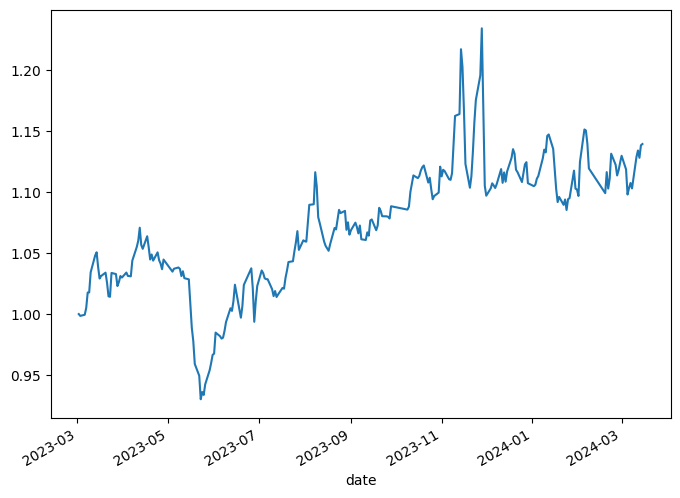

In [39]:
plt.figure(figsize=(8, 6))
df['portfolio_value'].plot()
plt.show()

In [40]:
end = time.time()
runTime = (end - start) // 60   # runTime是多少分钟
print("程序运行时间为：", runTime, "分钟")

程序运行时间为： 185.0 分钟
